# Linear Models

This notebook mainly contains:<br>
(1) Definition of task contrasts and predictor modalities to use as basis for model fitting<br>
(2) Fitting of one model per input modality<br>
(3) Result Calculation<br>
(4) More in depth visualization for RS-FC-PCA and Microstructural results<br>
(5) within parcel models for both modalities<br>

**Inputs**

Single file containing all the 47 task contrasts for all 254 subejcts (for LH)<br>
`/scratch/users/robert.scholz2/acc_dists/all_47_tasks_254_full_unrelated.raw.npy`

Single files containing the data of all 254 subejcts per predictor modality (for LH)<br>
given as dics, with subject numbers beeing the key, and values beeing of shape (29696, d)<br>
e.g. for "RS-PCA200": `all_grads_254_full_unrelated.L.corrcoef.procrAlignGrp.npy`


Full Task Retest baseline<br>
`results/scores/retest_hcp.40subjs.47tasks.retest_scores.from_zscored.npy`

Full Task baseline when always predicting group averages<br>
`results/scores/retest_hcp.40subjs.47tasks.group_mean_scores.from_zscored.npy`

Full Task Retest vw-accuracy baseline<br>
`results/scores/retest_hcp.40subjs.47tasks.vertexw_acc_across_subjs.from_zscored.npy`

A Parcellation (for the within parcel scores, and within parcel models)<br>
`/home/users/robert.scholz2/res/atlases/lausanne18_cammoun12/fsLR32k/lausanne08.sc4.fslr32k.LR.dlabel.nii`


**Outputs**

Results (i.e. scores & information) + in extended version with individual task contrast predictions<br>
`results/scores/linear_regression_scores_and_info_v3.yfull.aa.npy`<br>
`results/scores/linear_regression_scores_and_info_v3.yfull.aa.extended.npy`

Results (i.e. scores & information) + in extended version with individual task contrast predictions<br>
`results/scores/within_parcel_models.lausanne.51test_subjs.47tasks.all_modalities.from_zscored.yfull.npy`

Data saved for external plotting:<br>
`data/xdata_microstruc.51subj.test.yfull.npy`<br>
`data/xdata_rspca.51subj.200comps.test.yfull.npy`<br>
`results/scores/linear_regression_scores_and_info_v3.yfull.aa.extended.small.npy`<br>







In [ ]:
# General libraries
import torch, scipy, os, 
import numpy as np
from tqdm.auto import tqdm

import brainspace
import nibabel as nib
import hcp_utils as hcp

# helper functions for data loading and predictions
from lib.data_loading import load_xy_data, gather_modalities
from lib.linear_models import predict_y_from_x, predict_from_modality_file, approximate_best_alphas, score

# Machine learning
import sklearn.linear_model
from sklearn.utils import Bunch
from sklearn.model_selection import train_test_split, ShuffleSplit

import sys
sys.path.append("/home/mpg02/MLSC/robert.scholz2/.local/lib/python3.7/site-packages")
from himalaya.kernel_ridge import KernelRidgeCV
from himalaya.ridge import RidgeCV

# Model Evaluations
from lib.stats import compute_all_scores, compute_scores
from lib.stats import comp_dice, comp_corr, r2_score, comp_tsss_similiarity, comp_cosine_similiarity
from lib.stats import compute_batch_differentiability_score
desired_scores = {"corr": comp_corr, "r2_score": r2_score};

# Plotting libraries

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import cmasher as cmr
import cmcrameri.cm as cmc
from lib.plotting import fig2tightPIL,infer_colorbar, paste_centrally, image_grid, plot_corr_scores, plot_29k, plot_gen_surf2, centered_minmax
def fxdcolorbar(mappable, *args,**kwargs): from mpl_toolkits.axes_grid1 import make_axes_locatable; last_axes = plt.gca(); ax = mappable.axes; fig = ax.figure; divider = make_axes_locatable(ax);  cax = divider.append_axes("right", size="5%", pad=0.05); cbar = fig.colorbar(mappable, cax=cax, *args,**kwargs); plt.sca(last_axes); return cbar;
stub = os.path.dirname(brainspace.__file__) + "/datasets/surfaces/"
cmap_coeffs = "cmr.prinsenvlag_r" #cmc.vik #"PiYG"

In [3]:
# general data 
data_dir = "/scratch/users/robert.scholz2/acc_dists/"
subjs=np.loadtxt("data/subjs_hcp254_full_unrelated.txt").astype(int).astype(str);

## Prediction targets: task maps

In [5]:
# all 47 non redundant contrasts
fn = "/scratch/users/robert.scholz2/acc_dists/all_47_tasks_254_full_unrelated.raw.npy"
yfull_task_data=np.load(fn, allow_pickle=True).item()

unique_contrasts = np.loadtxt("data/task_contrasts_47_unique_names.txt", dtype=str);
contrast_ids_to_show = [8, 38, 16, 2, 27, 24, 5, 44, 21]
tnames_mid = ["Lang S-M", "WM2-0", "Motor Cue-Avg", "Emoti Face-Shape", "Social TOM-Rand", "Rel-Match", "Gamble Rew-Pun" ,"WM Face-Av", "Motor T-Avg"]

print("Number of subjects in task data file:", len(yfull_task_data))
print("First 5 subject ids:", list(yfull_task_data.keys())[:5])
print("Each subjects' task data has the shape:", yfull_task_data["100206"].shape)

Number of subjects in task data file: 254
First 5 subject ids: ['100206', '100610', '101006', '101309', '101915']
Each subjects' task data has the shape: (29696, 47)


In [6]:
len(unique_contrasts)

47

## Predictors: different modalities

In [7]:
pred_files = {
    "RS-ICA200": "all_ICAmapsV2_254_full_unrelated.L.c200.npy",
    "RS-PCA200" : "all_grads_254_full_unrelated.L.corrcoef.procrAlignGrp.npy",
    "Distance to Parcels (raw)": "all_dists_254_full_unrelated.centroid_dist.raw.npy",
    "SC Blueprints": "all_blueprints_BPsubset247.npy",
    "SEmodes": "all_SEmodes_254_full_unrelated.L.midthickness_MSMAll.noMW.surf.SEmodes.procAlignGrp.npy",
    "Distance-PCAgra" : "all_dists_254_full_unrelated.29x200.grPCA_aligned.L.npy",
    "FS-StructuralMaps": "all_fs_struct_254_full_unrelated.L.npy",
}

## Baseline Scores

In [8]:
# All the baseline scores are on a per task basis; that is they have a shape of (n_tasks=47,)


# Full Task Retest baseline
fn = "results/scores/retest_hcp.40subjs.47tasks.retest_scores.from_zscored.npy"
retest_bl = np.load(fn, allow_pickle=1).item()
print(retest_bl.keys())
sc_retest_corr =retest_bl["mean_corr"]
sc_retest_diff = retest_bl["diff"]
print(sc_retest_corr.shape, sc_retest_diff.shape)

# Full Task baseline when always predicting group averages
fn = "results/scores/retest_hcp.40subjs.47tasks.group_mean_scores.from_zscored.npy"
grp_bl = np.load(fn, allow_pickle=1).item()
print(grp_bl.keys())
sc_gr_corr =grp_bl["mean_corr"]       
print(sc_gr_corr.shape)

# Baseline when predicting the individual task residuals         
fn = "results/scores/retest_hcp.40subjs.47tasks.retest_scores.yresid.from_zscored.npy"
resid_bl = np.load(fn, allow_pickle=1).item()
print(resid_bl.keys())
sc_retest_yresid_corr = resid_bl["mean_corr"] 
sc_retest_yresid_diff = resid_bl['diff'] 
print(sc_retest_yresid_corr.shape, sc_retest_yresid_diff.shape)


dict_keys(['mean_corr', 'diff', 'scoresd'])
(47,) (47,)
dict_keys(['mean_corr', 'diff', 'scoresd'])
(47,)
dict_keys(['mean_corr', 'diff', 'scoresd', 'info'])
(47,) (47,)


In [9]:
print("Contrasts to show:", unique_contrasts[contrast_ids_to_show])
print("\nYfull Retest corr baseline:", sc_retest_corr[contrast_ids_to_show].round(3))
print("Yfull Retest diff baseline:", sc_retest_diff[contrast_ids_to_show].round(3))
print("")
print("Yfull Group corr baseline:", sc_gr_corr[contrast_ids_to_show].round(3))
print("")
print("Yresid Retest corr baseline:", sc_retest_yresid_corr[contrast_ids_to_show].round(3))
print("Yresid Retest diff baseline:", sc_retest_yresid_diff[contrast_ids_to_show].round(3))

Contrasts to show: ['LANGUAGE_STORY-MATH' 'WM_2BK-0BK' 'MOTOR_CUE-AVG' 'EMOTION_FACES-SHAPES'
 'SOCIAL_TOM-RANDOM' 'RELATIONAL_REL-MATCH' 'GAMBLING_REWARD-PUNISH'
 'WM_FACE-AVG' 'MOTOR_T-AVG']

Yfull Retest corr baseline: [0.704 0.384 0.6   0.434 0.348 0.195 0.048 0.326 0.367]
Yfull Retest diff baseline: [0.268 0.21  0.225 0.218 0.169 0.11  0.035 0.138 0.122]

Yfull Group corr baseline: [0.665 0.427 0.624 0.483 0.439 0.315 0.202 0.439 0.513]

Yresid Retest corr baseline: [0.478 0.252 0.351 0.275 0.202 0.117 0.035 0.167 0.157]
Yresid Retest diff baseline: [0.489 0.257 0.359 0.282 0.207 0.12  0.036 0.171 0.16 ]


# >> Batch regression [core]

In [10]:
from lib.utils import get_machine_stats
get_machine_stats(verb=1, gpu=0, ret=0, sep="  ", proc=1, rnd=2, per_cpu=1)

cpu: 0.2%  vmem: 3.9%  vmem_tot: 376.31gb  n_cpus: 96  pid: 56403  proc_mem: 1.66gb  proc_mem/tot: 0.44%  proc_n_cpus: 12  proc_cum_cpu: 0.0%  proc_avg_cpu: 0.0%  proc_assigned_cpus: [3, 4, 5, 27, 28, 29, 51, 52, 53, 75, 76, 77]  assigned_cpu_util_%: [0.7 0.8 0.4 1.3 0.5 2.3 0.6 0.5 0.6 1.1 3.4 2.1]


In [11]:
unimodal_regressors = ["RS-PCA200","RS-ICA200", 'SC Blueprints', 'Distance to Parcels (raw)', 'SEmodes', 'Distance-PCAgra', 'FS-StructuralMaps']
# RS-PCA combined with any other of the unimodal regressors
combinations =  []
for add_modality in unimodal_regressors[1:]: combinations.append(['RS-PCA200' , add_modality])

In [12]:
cache= {}
regr_data= {}

z_score_predictors_along_dim = 1# 1 ~ along spatial axis; 0~ across subjects
add_info= "" # could be i.e 
lmodel = "linear" #"ridge"

In [13]:

xcombs= [[u] for u in unimodal_regressors]
#xcombs= [["RS-PCA200"]]

for combination in xcombs: 
  comb_name = " + ".join(combination) + add_info;
  print("____" * 20 + "\nModalities:", comb_name)
  if comb_name in regr_data.keys(): continue; 
  #isubjs, y_train, y_train_pred, y_test, y_test_pred, skr = pred_combined(combination, pred_files, modality_cache=cache)
  comb_predictors = gather_modalities(subjs, combination, pred_files, data_dir = data_dir, zscore_predictors=False, modality_cache=cache);
  
  #isubjs, xdata, ydata = load_xy_data(subjs, data_dir, comb_predictors, yresid_task_data)
  isubjs, xdata, ydata = load_xy_data(subjs, data_dir, comb_predictors, yfull_task_data)
  if not(z_score_predictors_along_dim is None):
    print("z-scoring predictors along d=", z_score_predictors_along_dim)
    xdata = scipy.stats.zscore(xdata, axis= z_score_predictors_along_dim)
  
  #x_train, x_test, y_train, y_test = train_test_split(xdata, ydata, test_size=0.2, shuffle=False)
  y_train, y_train_pred, y_test, y_test_pred, skr = predict_y_from_x(xdata, ydata, lmodel=lmodel, verbose=1)
  scoresd, diff_scores_test = score(y_test_pred, y_test);
  
  regr_data[comb_name] = Bunch(scoresd=scoresd, diff_scores_test=diff_scores_test, isubjs=isubjs, \
     y_train=y_train, y_train_pred=y_train_pred, y_test=y_test, y_test_pred=y_test_pred, skr=skr)
  
  print("Correlation:", scoresd.corr.mean(0).round(3))
  print("Differentiability:", diff_scores_test.round(3))

________________________________________________________________________________
Modalities: RS-PCA200


Concatenating predictors: 100%|██████████| 254/254 [00:02<00:00, 119.75it/s]


Gathered data from 254 subjects. Per subject data is of shape: (29696, 200)
0 missing subjects:  []
z-scoring task maps along the spatial dimension
All 254 have task data attached to them
z-scoring predictors along d= 1
(203, 29696, 200) (203, 29696, 47) (51, 29696, 200) (51, 29696, 47)
(6028288, 200) (6028288, 47)
Correlation: [0.52  0.524 0.42  0.615 0.626 0.102 0.447 0.49  0.688 0.602 0.391 0.352
 0.444 0.441 0.454 0.457 0.594 0.267 0.304 0.348 0.401 0.426 0.68  0.696
 0.318 0.666 0.69  0.417 0.587 0.562 0.601 0.577 0.493 0.487 0.594 0.574
 0.652 0.629 0.456 0.595 0.58  0.641 0.627 0.302 0.382 0.369 0.249]
Differentiability: [0.107 0.101 0.105 0.159 0.158 0.033 0.166 0.174 0.196 0.146 0.11  0.098
 0.102 0.086 0.081 0.119 0.134 0.045 0.044 0.044 0.04  0.051 0.144 0.157
 0.094 0.146 0.167 0.122 0.16  0.173 0.153 0.15  0.118 0.129 0.128 0.129
 0.178 0.146 0.159 0.153 0.169 0.151 0.15  0.077 0.08  0.092 0.05 ]
_____________________________________________________________________________

Concatenating predictors: 100%|██████████| 254/254 [00:02<00:00, 105.05it/s]


Gathered data from 254 subjects. Per subject data is of shape: (29696, 200)
0 missing subjects:  []
z-scoring task maps along the spatial dimension
All 254 have task data attached to them
z-scoring predictors along d= 1
(203, 29696, 200) (203, 29696, 47) (51, 29696, 200) (51, 29696, 47)
(6028288, 200) (6028288, 47)
Correlation: [0.513 0.514 0.384 0.592 0.606 0.092 0.428 0.483 0.689 0.595 0.35  0.32
 0.415 0.408 0.442 0.428 0.583 0.24  0.303 0.338 0.369 0.398 0.684 0.698
 0.288 0.661 0.683 0.408 0.564 0.537 0.586 0.557 0.475 0.471 0.579 0.57
 0.631 0.618 0.443 0.572 0.557 0.626 0.615 0.261 0.367 0.329 0.228]
Differentiability: [0.097 0.089 0.081 0.137 0.139 0.032 0.148 0.158 0.182 0.132 0.087 0.087
 0.087 0.068 0.077 0.099 0.121 0.036 0.04  0.053 0.039 0.045 0.141 0.15
 0.07  0.134 0.153 0.117 0.135 0.15  0.138 0.126 0.102 0.118 0.116 0.123
 0.155 0.134 0.14  0.13  0.149 0.137 0.135 0.057 0.065 0.068 0.038]
________________________________________________________________________________

Concatenating predictors: 100%|██████████| 254/254 [00:00<00:00, 349.62it/s]


Gathered data from 247 subjects. Per subject data is of shape: (29696, 41)
7 missing subjects:  ['110613', '140117', '181131', '195849', '201515', '433839', '656657']
z-scoring task maps along the spatial dimension
All 247 have task data attached to them
z-scoring predictors along d= 1
(197, 29696, 41) (197, 29696, 47) (50, 29696, 41) (50, 29696, 47)
(5850112, 41) (5850112, 47)
Correlation: [0.412 0.331 0.27  0.389 0.409 0.057 0.246 0.305 0.341 0.434 0.261 0.225
 0.328 0.302 0.339 0.333 0.443 0.182 0.31  0.286 0.229 0.234 0.492 0.509
 0.181 0.444 0.454 0.223 0.396 0.348 0.412 0.396 0.345 0.321 0.44  0.424
 0.436 0.453 0.258 0.408 0.369 0.457 0.446 0.168 0.277 0.231 0.18 ]
Differentiability: [ 0.004  0.004  0.005  0.005  0.005  0.     0.005  0.003  0.006  0.006
  0.005  0.007  0.003  0.005  0.002  0.005  0.005  0.003  0.005  0.002
  0.001  0.001  0.004  0.005  0.004  0.005  0.006  0.001  0.005  0.006
  0.005  0.005  0.004  0.004  0.009  0.005  0.006  0.007  0.003  0.005
  0.006  0.007  

Concatenating predictors: 100%|██████████| 254/254 [00:02<00:00, 96.31it/s] 


Gathered data from 254 subjects. Per subject data is of shape: (29696, 224)
0 missing subjects:  []
z-scoring task maps along the spatial dimension
All 254 have task data attached to them
z-scoring predictors along d= 1
(203, 29696, 224) (203, 29696, 47) (51, 29696, 224) (51, 29696, 47)
(6028288, 224) (6028288, 47)
Correlation: [0.479 0.421 0.356 0.486 0.5   0.071 0.319 0.384 0.471 0.499 0.296 0.252
 0.389 0.382 0.422 0.377 0.513 0.233 0.315 0.374 0.352 0.385 0.591 0.605
 0.231 0.541 0.556 0.311 0.472 0.431 0.492 0.474 0.407 0.406 0.515 0.496
 0.522 0.536 0.31  0.484 0.461 0.54  0.529 0.261 0.334 0.305 0.209]
Differentiability: [ 0.003  0.001  0.     0.005  0.004  0.004  0.     0.001  0.001 -0.003
  0.001  0.003  0.003 -0.002  0.001  0.002 -0.004 -0.003 -0.003  0.002
 -0.004 -0.001  0.    -0.     0.003 -0.003  0.001 -0.004 -0.002 -0.002
  0.    -0.001 -0.001  0.001  0.003  0.    -0.003  0.001 -0.002 -0.003
 -0.001  0.001 -0.001  0.005  0.004  0.006  0.002]
_____________________________

Concatenating predictors: 100%|██████████| 254/254 [00:02<00:00, 109.36it/s]


Gathered data from 254 subjects. Per subject data is of shape: (29696, 200)
0 missing subjects:  []
z-scoring task maps along the spatial dimension
All 254 have task data attached to them
z-scoring predictors along d= 1
(203, 29696, 200) (203, 29696, 47) (51, 29696, 200) (51, 29696, 47)
(6028288, 200) (6028288, 47)
Correlation: [0.549 0.551 0.47  0.602 0.616 0.102 0.428 0.485 0.636 0.602 0.415 0.38
 0.504 0.488 0.51  0.483 0.606 0.311 0.366 0.469 0.499 0.503 0.689 0.703
 0.312 0.679 0.695 0.43  0.58  0.551 0.615 0.577 0.511 0.518 0.632 0.592
 0.647 0.655 0.414 0.6   0.587 0.667 0.636 0.35  0.425 0.427 0.285]
Differentiability: [ 0.002  0.003  0.003  0.003  0.002 -0.     0.001  0.001  0.003  0.002
  0.002  0.002  0.002  0.001  0.001  0.002  0.002  0.001  0.001  0.002
  0.001  0.001  0.002  0.002 -0.     0.003  0.004  0.004  0.002  0.001
  0.002  0.002  0.002  0.001  0.002  0.002  0.002  0.002  0.002  0.002
  0.001  0.002  0.002  0.002  0.002  0.003  0.002]
______________________________

Concatenating predictors: 100%|██████████| 254/254 [00:02<00:00, 118.42it/s]


Gathered data from 254 subjects. Per subject data is of shape: (29696, 200)
0 missing subjects:  []
z-scoring task maps along the spatial dimension
All 254 have task data attached to them
z-scoring predictors along d= 1
(203, 29696, 200) (203, 29696, 47) (51, 29696, 200) (51, 29696, 47)
(6028288, 200) (6028288, 47)
Correlation: [0.522 0.504 0.427 0.564 0.578 0.093 0.394 0.452 0.576 0.569 0.377 0.339
 0.472 0.458 0.483 0.448 0.575 0.292 0.352 0.448 0.463 0.47  0.656 0.669
 0.286 0.637 0.647 0.39  0.542 0.509 0.574 0.539 0.472 0.475 0.591 0.556
 0.603 0.61  0.381 0.558 0.541 0.624 0.597 0.326 0.394 0.392 0.258]
Differentiability: [ 0.002  0.001  0.001  0.003  0.003 -0.001  0.002  0.004 -0.     0.
  0.002  0.004  0.003  0.002  0.001  0.002 -0.     0.002  0.     0.003
  0.001  0.002  0.    -0.    -0.002  0.    -0.002 -0.001 -0.001 -0.001
  0.001 -0.002 -0.001 -0.001  0.001  0.    -0.001 -0.     0.001 -0.001
 -0.001  0.001 -0.001  0.004  0.003  0.005  0.001]
________________________________

Concatenating predictors: 100%|██████████| 254/254 [00:00<00:00, 5539.51it/s]

Gathered data from 254 subjects. Per subject data is of shape: (29696, 5)


0 missing subjects:  []
z-scoring task maps along the spatial dimension
All 254 have task data attached to them
z-scoring predictors along d= 1
(203, 29696, 5) (203, 29696, 47) (51, 29696, 5) (51, 29696, 47)
(6028288, 5) (6028288, 47)
Correlation: [0.167 0.133 0.104 0.146 0.141 0.003 0.086 0.099 0.101 0.196 0.084 0.1
 0.05  0.045 0.028 0.062 0.228 0.078 0.068 0.027 0.084 0.025 0.204 0.189
 0.045 0.126 0.085 0.101 0.088 0.077 0.116 0.123 0.097 0.092 0.137 0.137
 0.111 0.136 0.047 0.101 0.091 0.135 0.14  0.071 0.1   0.07  0.084]
Differentiability: [ 0.004 -0.     0.01   0.009  0.011  0.006  0.015  0.014 -0.002  0.003
  0.004 -0.006  0.003 -0.002  0.002  0.001 -0.001  0.006 -0.004 -0.003
  0.002  0.     0.002  0.004 -0.003 -0.003  0.004  0.007  0.001  0.009
  0.006  0.003  0.004  0.007  0.006  0.003  0.005  0.005 -0.001  0.002
  0.009  0.007  0.003  0.007 -0.004  0.007 -0.005]


In [56]:
# Save the results, and extended data (uncomment the np.save lines)
fn = "results/scores/linear_regression_scores_and_info_v3.yfull.aa.extended.npy"
#np.save(fn, regr_data)
!ls -ash {fn}

keep = ["scoresd", "diff_scores_test", "isubjs", "skr"]
sm_regr_data = {k: {i: v[i] for i in keep} for k,v in regr_data.items()}
fn = "results/scores/linear_regression_scores_and_info_v3.yfull.aa.npy"
#np.save(fn, sm_regr_data)
!ls -ash {fn}

636K data/ridge_regression_scores_and_info_v3.yfull.aa.npy


# Results

## Accuracy (Correlation) & Discriminability

In [ ]:
# Load data from checkpoint
#fn = "results/scores/linear_regression_scores_and_info_v3.yfull.aa.extended.npy"
fn = "results/scores/linear_regression_scores_and_info_v3.yfull.aa.npy"
regr_data = np.load(fn, allow_pickle=1).item()
regr_data = {k : Bunch(**v) for k,v in regr_data.items()}

# get the scores from the regression result data 
cdict = {k: v["scoresd"] for k,v in regr_data.items()}
ddict = {k: v["diff_scores_test"] for k,v in regr_data.items()}

# List type of model used, and all the predictor modalities contained in the checkpoint
print(regr_data['RS-PCA200']['skr'], regr_data.keys())

In [59]:
unique_contrasts = np.loadtxt("data/task_contrasts_47_unique_names.txt", dtype=str);
ctrtasks = [uc.split("_")[0] for uc in unique_contrasts]
unique_tasks = np.unique(ctrtasks)
contr = {t:n for n,t in enumerate(unique_tasks)}
tasks_ids = [contr[t] for t in ctrtasks]
task_start_x = [np.where(np.array(tasks_ids)==n)[0][0] for n in np.unique(tasks_ids)]
task_mid_x = [np.where(np.array(tasks_ids)==n)[0].mean() for n in np.unique(tasks_ids)]
task_x = np.array([0, 3, 6, 14, 22, 25, 37])-0.3
uniq_tasks = ['EMOT', 'GAMBL', 'LANG', 'MOTOR', 'RELA', 'SOCIAL', 'WM']

In [61]:
import colorcet as cc
cmap_cat = cc.cm.glasbey_category10 # "tab20" #cc.cm.glasbey_dark 
import cmasher as cmr
cmap = "inferno"#plt.get_cmap('cmr.rainforest') # chroma

In [77]:
keys = [ 'RS-PCA200', 'RS-ICA200', 'FS-StructuralMaps', 'SC Blueprints', 'Distance to Parcels (raw)', 'Distance-PCAgra', 'SEmodes',  ]
unimodal_regressors = ["RS-PCA200","RS-ICA200", 'SC Blueprints', 'Distance to Parcels (raw)', 'SEmodes', 'Distance-PCAgra', 'FS-StructuralMaps']


/local/jobs/19617663/ipykernel_11026/730329264.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels([""] + unimodal_regressors)
/local/jobs/19617663/ipykernel_11026/730329264.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels([""] + unimodal_regressors)


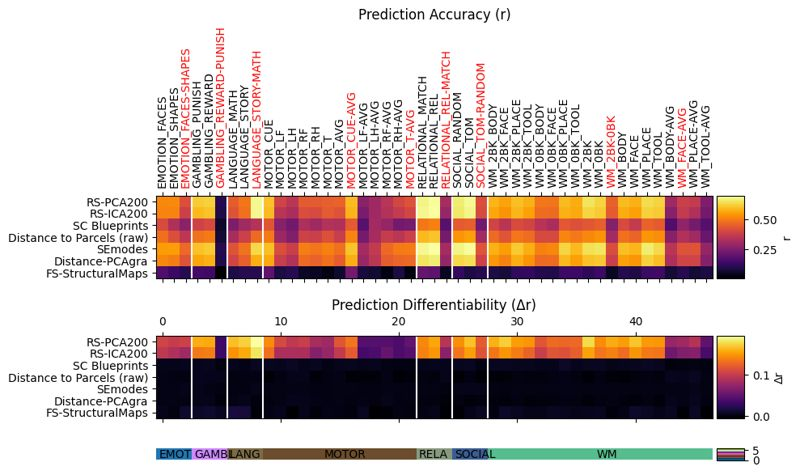

In [162]:
#carr = np.array([v["scoresd"].corr.mean(0) for k,v in regr_data.items()])
#darr = np.array([v["diff_scores_test"] for k,v in regr_data.items()])
carr = np.array([regr_data[v]["scoresd"].corr.mean(0) for v in unimodal_regressors])
darr = np.array([regr_data[v]["diff_scores_test"] for v in unimodal_regressors])

fig, axs = plt.subplots(3,1, figsize=(10,6), gridspec_kw={'height_ratios': [3, 3, 0.5]}) 

im = axs[0].matshow(carr, cmap=cmap); fxdcolorbar(im, ax = axs[0], label="r"); axs[0].set_title("Prediction Accuracy (r)");
axs[0].vlines(np.array(task_start_x)-0.5, -0.5, 6.5, colors="white")
axs[0].set_xticks(np.arange(len(unique_contrasts)))
axs[0].set_xticklabels(unique_contrasts, ma="right", rotation=90);
axs[0].set_yticklabels([""] + unimodal_regressors)

for label in np.array(axs[0].get_xticklabels())[contrast_ids_to_show]:
  label.set_color("red")


im = axs[1].matshow(darr, cmap=cmap); fxdcolorbar(im, ax = axs[1], label="Δr"); axs[1].set_title("Prediction Differentiability (Δr)");
axs[1].vlines(np.array(task_start_x)-0.5, -0.5, 6.5, colors="white")
axs[1].set_yticklabels([""] + unimodal_regressors)

im = axs[2].matshow([tasks_ids], cmap=cmap_cat); cb = fxdcolorbar(im, ax = axs[2]); axs[2].axis('off')
for n, x in enumerate(task_x): axs[2].text(x, 0.3, uniq_tasks[n])
plt.tight_layout()
saveparams=dict(bbox_inches='tight', pad_inches=0, transparent="True", dpi = 300)
plt.savefig("results/plots/matplot_all_unimodal.predictions.1.spatial_zscore.yfull.png", **saveparams)
#plt.savefig("results/plots/matplot_all_unimodal.predictions.1.spatial_zscore.yfull.svg", **saveparams)



______________



In [95]:
#tnames = ["Lang S-M", "WM2-0", "Motor Cue-Avg", "Emoti Face-Shape", "Social TOM-Rand", "Rel-Match", "Gamble Rew-Pun" ,"WM Face-Av", "Motor T-Avg"]
tnames = ["Lang", "WM2", "Motor Cue", "Emoti", "SocTOM", "Rel", "GRew" ,"WMFace", "MotorT"]

(7, 47)


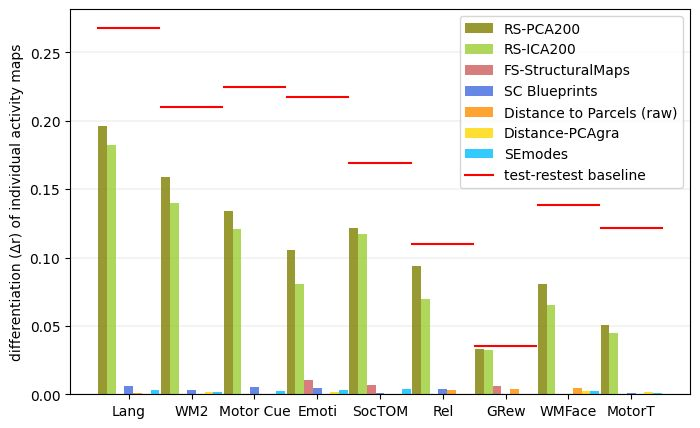

In [99]:
# plot all unimodal regressors
keys = [ 'RS-PCA200', 'RS-ICA200', 'FS-StructuralMaps', 'SC Blueprints', 'Distance to Parcels (raw)', 'Distance-PCAgra', 'SEmodes',  ]
cmap = ListedColormap(["black", "olive", "yellowgreen", "indianred", "royalblue", "darkorange", "gold", "deepskyblue", "black"])
                       
#keys = [k for k in regr_data.keys() if ("RS-PCA200" in k) and ("+" in k)]
ax = plt.figure(figsize=(8,5)).gca() # 4 plots in a row
ax.set_axisbelow(True); ax.grid(axis='y', lw=0.2);
hatches = None
dlab = "discriminability (Δr) of individual activity maps"
plot_corr_scores(cdict=ddict, keys=keys, sc_retest = sc_retest_diff[contrast_ids_to_show], task_names =None, selected_ids = contrast_ids_to_show, \
     hatches = hatches, ax=ax, cmap=cmap, ylabel=dlab, redby=0.025,alpha=0.8);
leg = ax.get_legend()
ax.legend(leg.legendHandles, [t._text for t in leg.texts], fontsize="medium", ncol=1);
ax.set_xlabel("")
ax.set_xticks(np.arange(len(tnames)))
ax.set_xticklabels(tnames, ma="right", rotation=0);
saveparams=dict(bbox_inches='tight', pad_inches=0, transparent="True", dpi = 300)
#plt.savefig("results/plots/barplot_all_unimodal.predictions.1.spatial_zscore.yfull.png", **saveparams)

In [100]:
from importlib import reload 
import lib.plotting
reload(lib.plotting)
from lib.plotting import plot_corr_scores

(7, 47)
(7, 47)


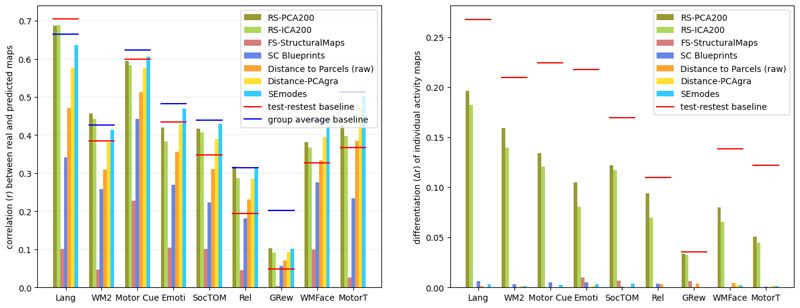

In [56]:
cid = contrast_ids_to_show
fig, axs = plt.subplots(1,2, figsize=(16,6)); # 4 plots in a row
params = dict(task_names=None, selected_ids=cid, keys=keys, cmap=cmap,alpha=0.8);

clab = "correlation (r) between real and predicted maps"
dlab = "differentiation (Δr) of individual activity maps"
plot_corr_scores(cdict=cdict, sc_retest = sc_retest_corr[cid],sc_group = sc_gr_corr[cid], ax=axs[0], ylabel=clab, **params);
plot_corr_scores(cdict=ddict, sc_retest = sc_retest_diff[cid], ax=axs[1], ylabel=dlab, **params );

for ax in axs: 
  leg = ax.get_legend();
  ax.legend(leg.legendHandles, [t._text for t in leg.texts], fontsize="medium", ncol=1);
  axs[0].set_axisbelow(True); axs[0].grid(axis='y', lw=0.2);
  ax.set_xlabel(""); ax.set_xticks(np.arange(len(tnames))); ax.set_xticklabels(tnames, ma="right", rotation=0);
    
saveparams=dict(bbox_inches='tight', pad_inches=0, transparent="True", dpi = 300)
plt.savefig("results/plots/barplot_all_unimodal.predictions.2.spatial_zscore.yfull.png", **saveparams)

In [73]:
print("Correlation:")
for k in keys: print(k, (30-len(k))*" ",  cdict[k].corr.mean(0)[cid].round(3))
print("\nDifferentiation:")
for k in keys: print(k, (30-len(k))*" ",  ddict[k][cid].round(3))

Correlation:
RS-PCA200                       [0.688 0.456 0.594 0.42  0.417 0.318 0.102 0.382 0.426]
RS-ICA200                       [0.689 0.443 0.583 0.384 0.408 0.288 0.092 0.367 0.398]
FS-StructuralMaps               [0.101 0.047 0.228 0.104 0.101 0.045 0.003 0.1   0.025]
SC Blueprints                   [0.341 0.258 0.443 0.27  0.223 0.181 0.057 0.277 0.234]
Distance to Parcels (raw)       [0.471 0.31  0.513 0.356 0.311 0.231 0.071 0.334 0.385]
Distance-PCAgra                 [0.576 0.381 0.575 0.427 0.39  0.286 0.093 0.394 0.47 ]
SEmodes                         [0.636 0.414 0.606 0.47  0.43  0.312 0.102 0.425 0.503]

Differentiation:
RS-PCA200                       [0.196 0.159 0.134 0.105 0.122 0.094 0.033 0.08  0.051]
RS-ICA200                       [0.182 0.14  0.121 0.081 0.117 0.07  0.032 0.065 0.045]
FS-StructuralMaps               [-0.002 -0.001 -0.001  0.01   0.007 -0.003  0.006 -0.004  0.   ]
SC Blueprints                   [0.006 0.003 0.005 0.005 0.001 0.004 0.    0.   

##  Vertex-wise predictions

In [46]:
# get the test-retest baseline
fn = "results/scores/retest_hcp.40subjs.47tasks.vertexw_acc_across_subjs.from_zscored.npy"
vertex_wise_maps = np.load(fn, allow_pickle=1).item()["vwmaps"]

In [47]:
# calculate the vertex wise scores
vwcs = {}
for modality in tqdm(unimodal_regressors):#tqdm(['RS-PCA200', 'FS-StructuralMaps']): #tqdm(regr_data.keys()):
  y_test = regr_data[modality].y_test
  y_test_pred = regr_data[modality].y_test_pred
  cs =compute_scores(y_test_pred.transpose(1,2,0), y_test.transpose(1,2,0), score_fn= comp_corr)
  vwcs[modality]=cs;

100%|██████████| 7/7 [11:51<00:00, 101.62s/it]


In [57]:
## Saving the scores as a separate file
sub_train, sub_test = train_test_split(subjs, test_size=0.2, shuffle=False)
fn = "results/scores/linear_regression_scores_and_info_v3.51test_subjs.47tasks.vertexw_acc_across_subjs.from_zscored.yfull.npy"
np.save(fn, dict(vwmaps=vwcs, test_subjs = sub_test));
!ls -ash {fn}

82M results/scores/retest_hcp.51test_subjs.47tasks.vertexw_acc_across_subjs.from_zscored.npy


**plotting of vertex wise scores**

In [116]:
# Create the figure subparts

imgs = []
cmap_vw = "coolwarm"
max_vs = []
for n, tn in enumerate(contrast_ids_to_show):
  maps = [vwcs["RS-PCA200"][:,tn], vertex_wise_maps[:, tn], vwcs["FS-StructuralMaps"][:,tn] ]
  #mapnames = [r"$\bf{" + task_names[tn]+ r"}$" +"\nVertex-wise accuracy: RS-PCA200", "FS-StructuralMaps", "Test-Retest Baseline"]
  mapnames = ["","",""]
  if tn==contrast_ids_to_show[0]: mapnames = ["Vertex-wise accuracy: RS-PCA200", "Test-Retest Baseline", "FS-StructuralMaps"]
  #mapnames = [r"$\bf{" + m + r"}$" for m in mapnames]
  #mapnames[0] = mapnames[0] +"\n" + r"$\bf{" + task_names[tn]+ r"}$"
  mapnames[0] = mapnames[0] +"\n" + r"$\it{" + tnames_mid[n]+ r"}$"
  #mapnames[0] = mapnames[0] +"\n" + task_names[tn]
  v = np.absolute(maps).max()
  max_vs.append(v)
  for i, (m,name) in enumerate(zip(maps, mapnames)): 
    print(name, end=" ");
    plot_29k(m, title=None, cmap=cmap_vw, colorbar=False, center_min_max=False, vmin=-v, vmax=v);
    #plt.title(name,  y=1.02, x=-0.99 , ha='left', va='top', pad=0) # weight='bold' if i==0 else -0.5
    plt.title(name,  y=1.02, x=-0.99 if i==0 else -0.45, ha='left', va='top', pad=0) # weight='bold' if i==0 else -0.5
    imgs.append(fig2tightPIL(close_fig=1, dpi=300))

Vertex-wise accuracy: RS-PCA200
$\it{Lang S-M}$ Test-Retest Baseline FS-StructuralMaps 
$\it{WM2-0}$   
$\it{Motor Cue-Avg}$   
$\it{Emoti Face-Shape}$   
$\it{Social TOM-Rand}$   
$\it{Rel-Match}$   
$\it{Gamble Rew-Pun}$   
$\it{WM Face-Av}$   
$\it{Motor T-Avg}$   

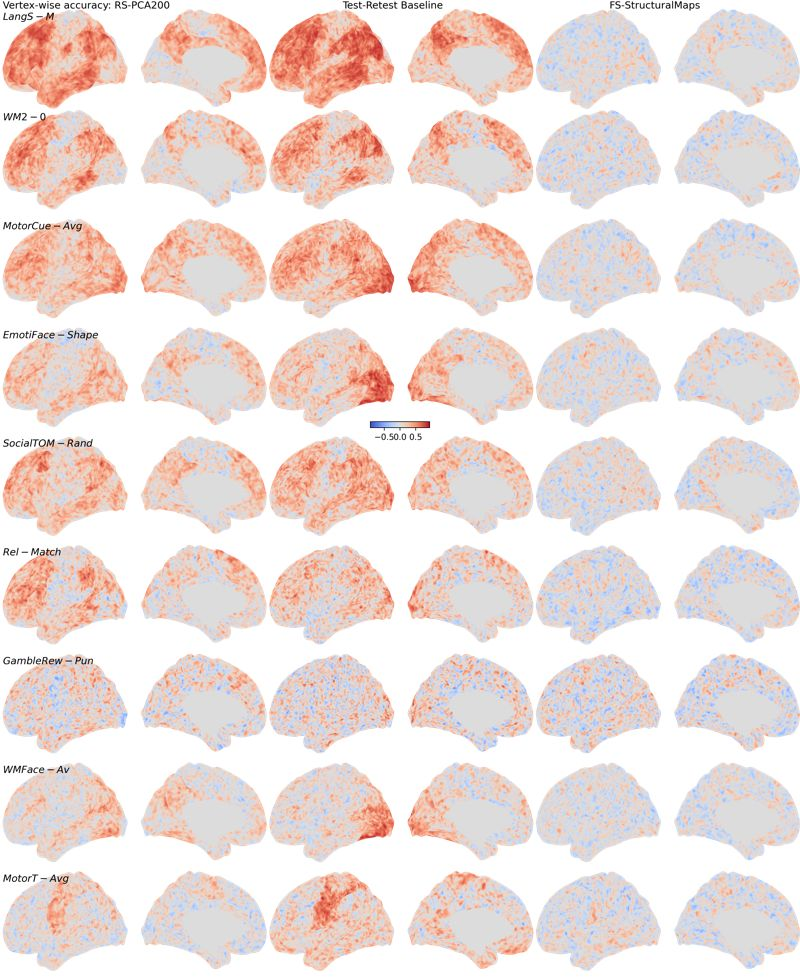

In [29]:
# Concatenate subparts, plot and save
imgg = image_grid(imgs, len(contrast_ids_to_show), 3)
cb = infer_colorbar(None, cminmax=False, vmin=-np.max(max_vs), vmax=np.max(max_vs), cmap=cmap_vw, aspect=10, shrink=0.2);
cbimg = fig2tightPIL(cb.ax.get_figure(), dpi=300, format="png", close_fig=1)
imggcb = paste_centrally(imgg, cbimg , uc=-0.12);
#imggcb.save("results/plots/vertex-wise-scores.pca+mstructure+rtbl.zspace.yfull.png")
imggcb

## Within parcel scores

In [36]:
## Load the parcellation(s)
"""
# Other Parcellation option
from brainspace.datasets import load_parcellation

lh_parc, rh_parc = load_parcellation('schaefer')
print("Schaefer400:\t",lh_parc.shape, lh_parc[hcp.vertex_info["grayl"]].shape)
print("HCP MMP1:\t",hcp.mmp.map_all[:29696].shape)

parcellation29k = hcp.mmp.map_all[:29696];
parcel_id_to_label = hcp.mmp.labels;"""

## lausanne
from lib.dist_tools import load_cifti_parcellation
cifti2 = "/home/users/robert.scholz2/res/atlases/lausanne18_cammoun12/fsLR32k/lausanne08.sc4.fslr32k.LR.dlabel.nii";
label_data, parcel_id_to_label = load_cifti_parcellation(cifti2, structure="left_cortex", verbose=1)
print(label_data.shape)
parcellation29k = label_data[hcp.vertex_info['grayl']]
excl = 1 

cifti_shape: (1, 64984)
BMA: 1 <nibabel.cifti2.cifti2_axes.BrainModelAxis object at 0x2b7425dd0820>
slice for strcuture: left_cortex slice(0, 32492, None)
label dict info: 225 items contained, first 10: {0: '???', 1: 'unknown', 2: 'lateralorbitofrontal_1', 3: 'lateralorbitofrontal_2', 4: 'lateralorbitofrontal_3', 5: 'lateralorbitofrontal_4', 6: 'lateralorbitofrontal_5', 7: 'lateralorbitofrontal_6', 8: 'lateralorbitofrontal_7', 9: 'parsorbitalis_1'}
label_data info: shape of  (32492,) i.e. [ 91. 104.  67. ... 195. 196. 195.]
unqiue label_data: 224 labels contained, i.e.: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
(32492,)


In [ ]:
from lib.stats import comp_dice, comp_corr, r2_score
from lib.stats import compute_all_scores, compute_scores, compute_batch_differentiability_score
from lib.linear_models import score

uniq_labels = list(np.unique(parcellation29k));
n_parcels = len(uniq_labels) # all labels in the left hemisphere

# calculate the vertex wise scores
corrd = {}
diffd = {}

for modality in tqdm(unimodal_regressors):#tqdm(['RS-PCA200', 'FS-StructuralMaps']): #tqdm(regr_data.keys()):
    y_test = regr_data[modality].y_test
    y_test_pred = regr_data[modality].y_test_pred

    n_tasks = y_test_pred.shape[-1]; 

    corrs = np.zeros((n_parcels, n_tasks))
    diffs = np.zeros((n_parcels, n_tasks))

    #pbar = tqdm(list(hcp.mmp.labels.items()), total=n_parcels)
    #for v, label in pbar:

    pbar = tqdm(enumerate(uniq_labels), total=n_parcels)
    for i, label_val in pbar:
        label = "" if parcel_id_to_label is None else parcel_id_to_label[label_val]
        mask = parcellation29k == label_val
        pbar.update()
        pbar.set_postfix_str(f"#{label_val} {label}, {mask.sum()}")
        if mask.sum()< 1: continue;
        scoresd, diff_scores_test = score(y_test_pred[:, mask, :], y_test[:, mask, :]);
        corrs[i, :] = scoresd.corr.mean(axis=0)
        diffs[i, :] = diff_scores_test
        
    corrd[modality] = corrs
    diffd[modality] = diffs
    

In [70]:
fn = "results/scores/linear_regression_scores_and_info_v3.51test_subjs.47tasks.within_parcel.lausanne.from_zscored.yfull.npy"
np.save(fn, dict(corr=corrd, discr=diffd, test_subjs = sub_test, parcel_id_to_label=parcel_id_to_label, parcellation29k=parcellation29k));
!ls -ash {fn}

2.0M results/scores/linear_regression_scores_and_info_v3.51test_subjs.47tasks.within_parcel.lausanne.from_zscored.yfull.npy


# ------

# In depth results for PCA and Structural Maps

**helper function**

In [60]:
def get_best_differentiated_subj_ids(y_test_pred, y_test, v=False):
  n_subjs= y_test.shape[0]; 
  n_tasks = y_test.shape[2]; 
  
  # dd indxes how well each subject is differentiated from all others on a per task basis
  dd = np.zeros((n_tasks, n_subjs))
  
  for tn in range(n_tasks): 
    corr_mat = np.corrcoef(y_test[:,:,tn],y_test_pred[:,:, tn])
    corr_mat = corr_mat[:n_subjs,n_subjs:]
    #plt.matshow(corr_mat)
  
    diagonal_corrs = np.diag(corr_mat);
    corr_tmp=corr_mat.copy()
    np.fill_diagonal(corr_tmp, np.nan)
    avg_cross_corrs = np.nanmean(corr_tmp,axis=0); 
    dd[tn, :] = (diagonal_corrs- avg_cross_corrs)

  best = np.argsort(dd, axis=1)[:, ::-1]
  best_across_tasks = np.argsort(dd.mean(axis=0))[::-1]
  if v: print("Best 10 differentiated subjects across tasks:", best_across_tasks[:10])
  return dd, best, best_across_tasks

In [53]:
def plot_sample_predictions2(tn, subjs, ydata, plot_subjs = [1,2,3,4], row_labels = ["predicted", "real", "retest"], \
            cmap="coolwarm", max_from=1, rm_percentile=99.99, verbose=False, uc=0.8, lc=0):
  
  suptitles =[]
  ymaps=[]

  #plot_subjs = best[tn,pos] if len(np.array(best).shape)>1 else best
  for ymap in ydata:
    maps = []
    for sn in plot_subjs:
      maps.append(ymap[sn,:,tn]);
    ymaps.append(maps)
    
  imgs = [];
  for mn, (maps) in enumerate(ymaps):
    if verbose: print(sn,"+",mn, end="|" )
    n_plots = len(maps)
    pcf = [f"img{n+1}_0_180_6.4" for n in range(n_plots)]
    transforms = {f"img{n+1}": hcp.left_cortex_data for n in range(n_plots)}
    
    afm = np.absolute((maps if max_from =="self" else ymaps[max_from])).flatten()
    v = afm[afm<np.percentile(afm, rm_percentile)].max()
    #v=np.absolute(maps).max()
    #print(len(maps), maps[0].shape, v)
    
    surfs= [stub+"conte69_32k_lh.gii"]*n_plots
    plot_gen_surf2(maps, surfs, transforms, plot_conf=pcf, cmap=cmap, vmin=-v, vmax=v);
    axs = plt.gcf().get_axes()
    #if mn==0: 
    for i,ax in enumerate(axs): 
      title = (f"Subject\n{subjs[plot_subjs[i]]}\n" if mn==0 else "") + row_labels[mn]
      ax.set_title(title, y=0.9, x=0.1, pad=0, ha='left', va='top')
    
    pil_img = fig2tightPIL(close_fig=1, dpi=300)
    cb = infer_colorbar(None, cminmax=0, vmin=-v,vmax=v, cmap=cmap, aspect=10, shrink=0.2);
    cbimg = fig2tightPIL(cb.ax.get_figure(), dpi=300, format="png", close_fig=1)
    img = paste_centrally(pil_img, cbimg, uc=uc, lc=lc);
    imgs.append(img)
  full_image = image_grid(imgs, len(ydata) ,1)
  return full_image

In [48]:
fn = "/scratch/users/robert.scholz2/dist_model/results/retest_hcp40.task_maps47.zscored.npy"
payload = np.load(fn, allow_pickle=1).item()

In [65]:
# Loading of the test / Retest Data
fn = "/scratch/users/robert.scholz2/dist_model/results/retest_hcp40.task_maps47.zscored.npy"
payload = np.load(fn, allow_pickle=1).item()
print(payload.keys())
tdata = payload["test_data"]
rdata = payload["retest_data"]

unique_contrasts2 = payload["info"]["unique_contrasts"]
subjs_retest_subset = payload["info"]["full_rt_subjs"]
zscore = payload["info"]["zscore"]
zscore, tdata.shape

dict_keys(['info', 'test_data', 'retest_data'])


(True, (40, 29696, 47))

In [66]:
#overlap_subjs = ['135528', '139839', '146129', '185442', '204521', '433839', '562345', '599671', '660951']

_,test_subjs,_,_ = train_test_split(subjs, subjs, test_size=0.2, shuffle=False)
print(len(test_subjs))
overlap_subjs = [s for s in test_subjs if s in subjs_retest_subset ]

index_in_big = [list(test_subjs).index(s) for s in overlap_subjs]
index_in_rts = [list(subjs_retest_subset).index(s) for s in overlap_subjs]
print(len(index_in_big),index_in_big)
print(len(index_in_rts),index_in_rts)

51
3 [1, 14, 26]
3 [31, 32, 34]


# PCA: Sample predictions and coefficients

In [55]:
modality= 'RS-PCA200'

## Plot individual subject predictions

In [61]:
y_test = reg_data[modality].y_test
y_test_pred = reg_data[modality].y_test_pred
subj_differentiation, best, best_across_tasks = get_best_differentiated_subj_ids(y_test_pred, y_test)

**we plot usually the 2 best differentiated subjects, then one from the middle (20th best differentiated) and then the worst differentiated**

maybe i should also plot alongside the Δr

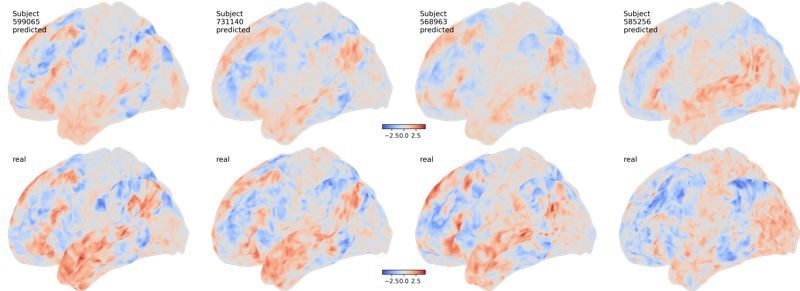

In [220]:
_,test_subjs,_,_ = train_test_split(subjs, subjs, test_size=0.2, shuffle=False)
tn = list(unique_contrasts).index("LANGUAGE_STORY-MATH")
img = plot_sample_predictions(tn, test_subjs, y_test_pred, y_test, best, cmap="coolwarm", verbose=False)
img.save("results/plots/rs_pca-lang.predictions.spatial_zscore.yfull.png")
img

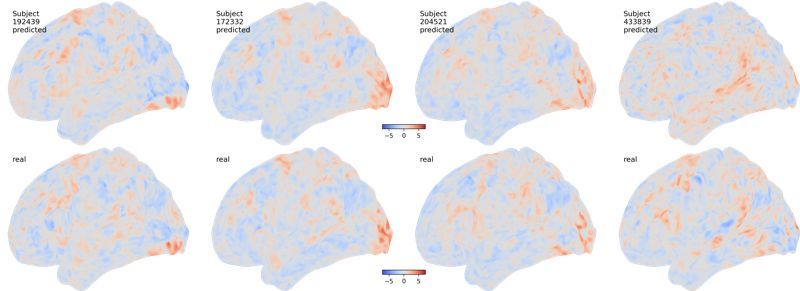

In [223]:
sd, best2, _  = get_best_differentiated_subj_ids(rdata, tdata)
tn = list(unique_contrasts).index("MOTOR_CUE-AVG")
img = plot_sample_predictions(tn, subjs_retest_subset, tdata, rdata, best2, cmap="coolwarm", verbose=False)
img.save("results/plots/rs_pca-lang.rt_bl.spatial_zscore.png")
img

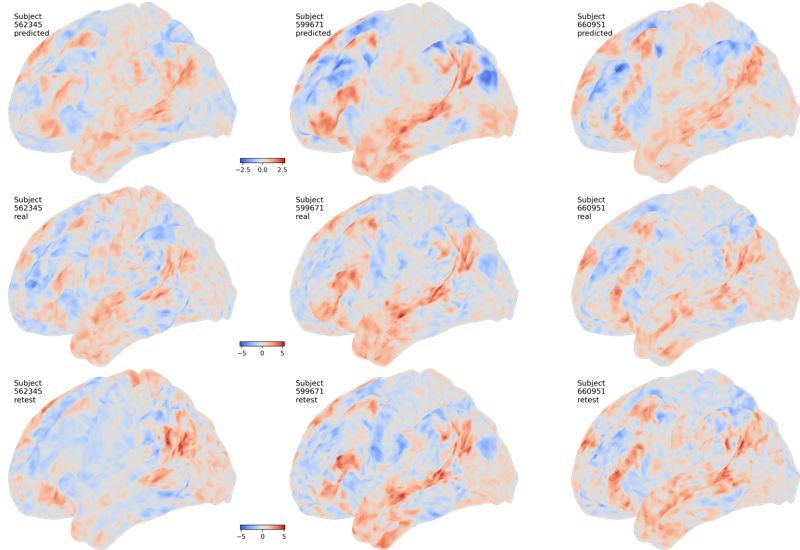

In [239]:
tn = list(unique_contrasts).index("LANGUAGE_STORY-MATH")
img = plot_sample_predictions_bl(tn, test_subjs[index_in_big], y_test_pred[index_in_big], y_test[index_in_big], \
                        payload["retest_data"][index_in_rts], [0,1,2], cmap="coolwarm", verbose=False)
img.save("results/plots/rs_pca-lang.predictions+rt_bl.spatial_zscore.yfull.png")
img

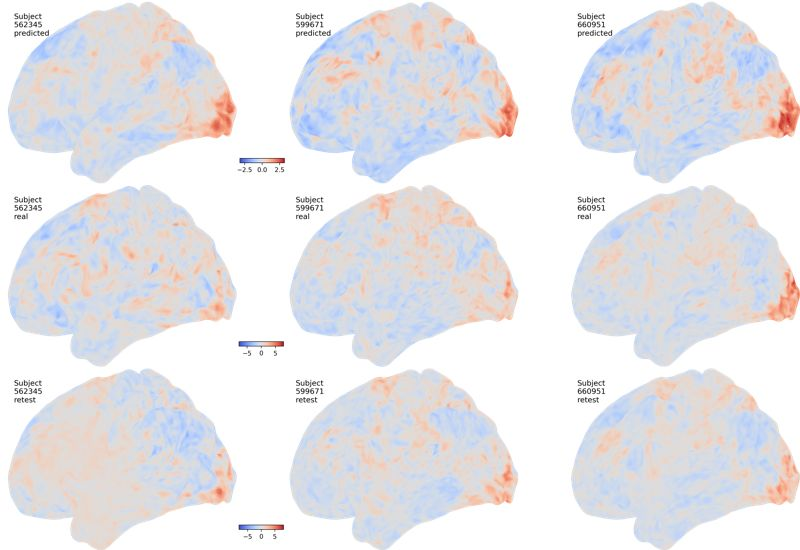

In [30]:
tn = list(unique_contrasts).index("MOTOR_CUE-AVG")
img = plot_sample_predictions_bl(tn, test_subjs[index_in_big], y_test_pred[index_in_big], y_test[index_in_big], \
                        payload["retest_data"][index_in_rts], [0,1,2], cmap="coolwarm", verbose=False)
img.save("results/plots/rs_pca-motor.predictions+rt_bl.spatial_zscore.yfull.png")
img

In [32]:
img.save("results/plots/rs_pca-motor.predictions+rt_bl.spatial_zscore.yfull.png")


## Plot the prediction coefficients

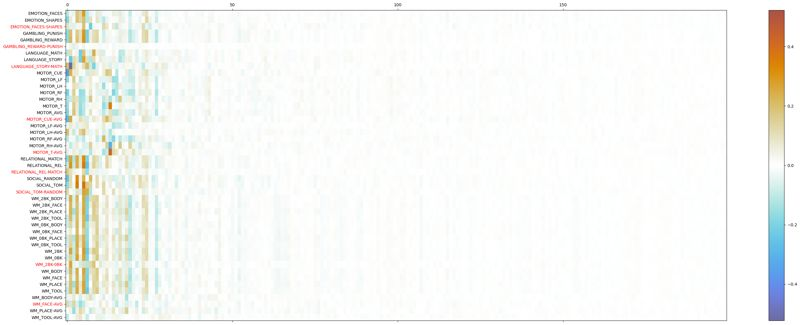

In [136]:
coeffs = regr_data[modality].skr.coef_ # shape (10, 224)

v = np.absolute(coeffs).max()
ax = plt.figure(figsize=(30,11)).gca()
im = ax.matshow(coeffs, cmap =cmap_coeffs , vmin=-v, vmax=v, aspect=2);  plt.colorbar(im, ax=ax)
plt.yticks(np.arange(len(unique_contrasts)), unique_contrasts);
for label in np.array(ax.get_yticklabels())[contrast_ids_to_show]: label.set_color("red")

plt.tight_layout()
#plt.savefig("results/plots/rs_pca.lin_weights.200.spatial_zscore.yfull.svg")
plt.savefig("results/plots/rs_pca.lin_weights.200.spatial_zscore.yfull.png")


In [105]:
#np.save("results/scores/rs_pca.lin_weights.200.spatial_zscore.yfull.npy", coeffs)

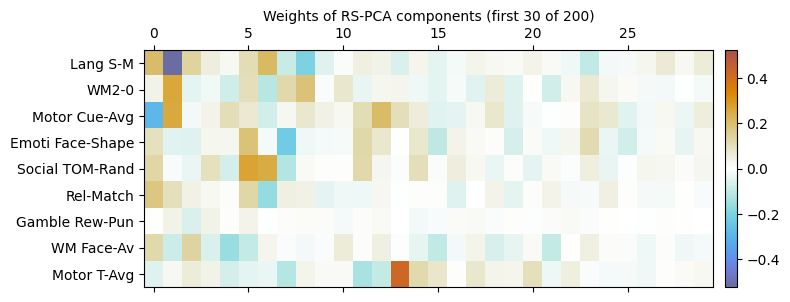

In [90]:
fig, axs = plt.subplots(1,1, figsize=(8,3.9)) # 4 plots in a row
axs=[axs];

coeffs2show = coeffs[contrast_ids_to_show,:]
best_coefficients = np.argsort(np.absolute(coeffs2show), axis=1)[:,::-1]

n_comps = 30;
data = coeffs2show[:,:n_comps]

aspr=(data.shape[1]/data.shape[0])/2.4
im = axs[0].matshow(data, cmap = cmap_coeffs, vmin=-v, vmax=v, aspect=aspr); 
#for (i, j), z in np.ndenumerate(coeffs2show): 
#  if j in best_coefficients[i,:3]: plt.text(j, i, '{:.2f}'.format(z), ha='center', va='center', size=5)

plt.colorbar(im,fraction=0.020, pad=0.02, ax=axs[0]);#fxdcolorbar(im, ax=axs[0]);#plt.colorbar(im, ax=axs[0]);
axs[0].set_yticks(np.arange(len(tnames_mid))); axs[0].set_yticklabels( tnames_mid);
axs[0].set_xlabel(f"Weights of RS-PCA components (first {n_comps} of 200)"); axs[0].xaxis.set_label_position('top') 
plt.tight_layout()
plt.savefig("results/plots/rs_pca.lin_weights.30.spatial_zscore.yfull.svg")
plt.savefig("results/plots/rs_pca.lin_weights.30.spatial_zscore.yfull.png")

In [91]:
aidxs = np.argsort(np.abs(coeffs), axis=1)
for n in range(len(tnames_mid)):
  txt = f"ten biggest coeffs for {tnames_mid[n]} ";
  tn = contrast_ids_to_show[n]
  print(txt, (44-len(txt))*" ", "at components:\t", idxs[tn][::-1][:10])

ten biggest coeffs for Lang S-M               at components:	 [ 1  6  0  8  2  5 23  7 27 29]
ten biggest coeffs for WM2-0                  at components:	 [ 1  8  7  6  5  4 10 21 23 18]
ten biggest coeffs for Motor Cue-Avg          at components:	 [ 0  1 12 11  4 13 23 18  6  8]
ten biggest coeffs for Emoti Face-Shape       at components:	 [ 7  5 11 23 15  0 14 25 12 19]
ten biggest coeffs for Social TOM-Rand        at components:	 [ 5  6  0 11  7 14  3  4 16 23]
ten biggest coeffs for Rel-Match              at components:	 [ 0  6  5  1 16 24  7 19  8  2]
ten biggest coeffs for Gamble Rew-Pun         at components:	 [ 2  3  1  5 14 17 10 12 22 16]
ten biggest coeffs for WM Face-Av             at components:	 [ 4  2  0 15 21  5  1 18  3 10]
ten biggest coeffs for Motor T-Avg            at components:	 [13 11 14  7 20 12 15 17  4  2]


In [92]:
idxs = np.argsort(np.abs(coeffs), axis=1)
for n in range(len(tnames_mid)):
  txt = f"ten biggest coeffs for {tnames_mid[n]} ";
  tn = contrast_ids_to_show[n]
  print(txt, (44-len(txt))*" ", "at components:\t", end="")
  for c in idxs[tn][::-1][:5]:
     print(f"c{c}", coeffs[tn, c], end=" | ")
  print("")

ten biggest coeffs for Lang S-M               at components:	c1 -0.5229514 | c6 0.21351421 | c0 0.20561004 | c8 -0.20145768 | c2 0.13977914 | 
ten biggest coeffs for WM2-0                  at components:	c1 0.2605337 | c8 0.187167 | c7 0.12146126 | c6 -0.112192646 | c5 0.10218103 | 
ten biggest coeffs for Motor Cue-Avg          at components:	c0 -0.28750518 | c1 0.253927 | c12 0.2060372 | c11 0.10900811 | c4 0.105446905 | 
ten biggest coeffs for Emoti Face-Shape       at components:	c7 -0.2230228 | c5 0.1878548 | c11 0.1251691 | c23 0.114760116 | c15 -0.10180624 | 
ten biggest coeffs for Social TOM-Rand        at components:	c5 0.26892942 | c6 0.25029197 | c0 0.12837489 | c11 0.121233836 | c7 -0.11868576 | 
ten biggest coeffs for Rel-Match              at components:	c0 0.17538586 | c6 -0.16242297 | c5 0.12769008 | c1 0.10118602 | c16 -0.052684985 | 
ten biggest coeffs for Gamble Rew-Pun         at components:	c2 -0.061508536 | c3 0.039672434 | c1 0.038618 | c5 0.036457628 | c14 -0.021

**show always three subjects next to each other and do 2 rows of real contrasts**

# FS Structural Maps: Sample predictions and coefficients

## Plot individual subject predictions

In [38]:
modality ='FS-StructuralMaps'
y_test = regr_data[modality].y_test
y_test_pred = regr_data[modality].y_test_pred
subj_differentiation, best, best_across_tasks = get_best_differentiated_subj_ids(y_test_pred, y_test)

**given that we do not have good differentiability, the predictions also look quite off**

In [59]:
"""y_test_pred[sn, :, tn]
data = y_test_pred[list(subjs).index("107422")].flatten()#.max()
np.where(np.abs(data)>1.5)[0].shape

tn = list(unique_contrasts).index("MOTOR_CUE-AVG")
data = y_test_pred[best[tn,[0,1,20,-1]],:,tn].flatten()#.max()
np.where(np.abs(data)>np.percentile(np.abs(data), 99.99))[0].shape

plt.hist(data, bins=1000);
plt.show()"""

(5,)

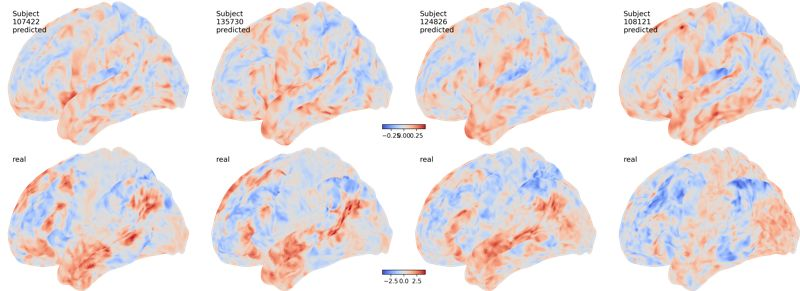

In [127]:
tn = list(unique_contrasts).index("LANGUAGE_STORY-MATH")
img = plot_sample_predictions2(tn, subjs, [y_test_pred, y_test], plot_subjs=best[tn,[0,1,20,-1]],  max_from="self")
img.save("results/plots/structural_maps-language.predictions.spatial_zscore.yfull.png")
img

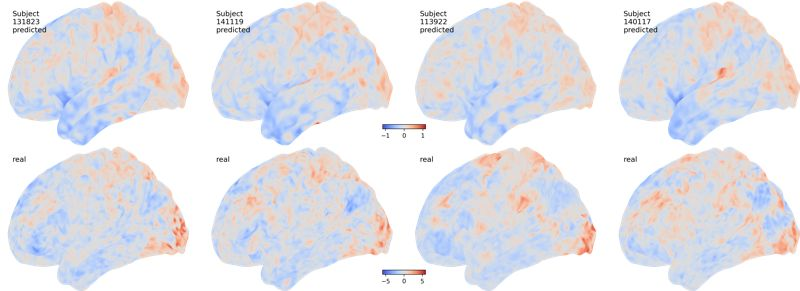

In [131]:
tn = list(unique_contrasts).index("MOTOR_CUE-AVG")
img = plot_sample_predictions2(tn, subjs, [y_test_pred, y_test], plot_subjs=best[tn,[0,1,20,-1]],  max_from="self")
img.save("results/plots/structural_maps-motor.predictions.spatial_zscore.yfull.png")
img

In [72]:
rl=['predicted', 'real', 'test', 'retest']

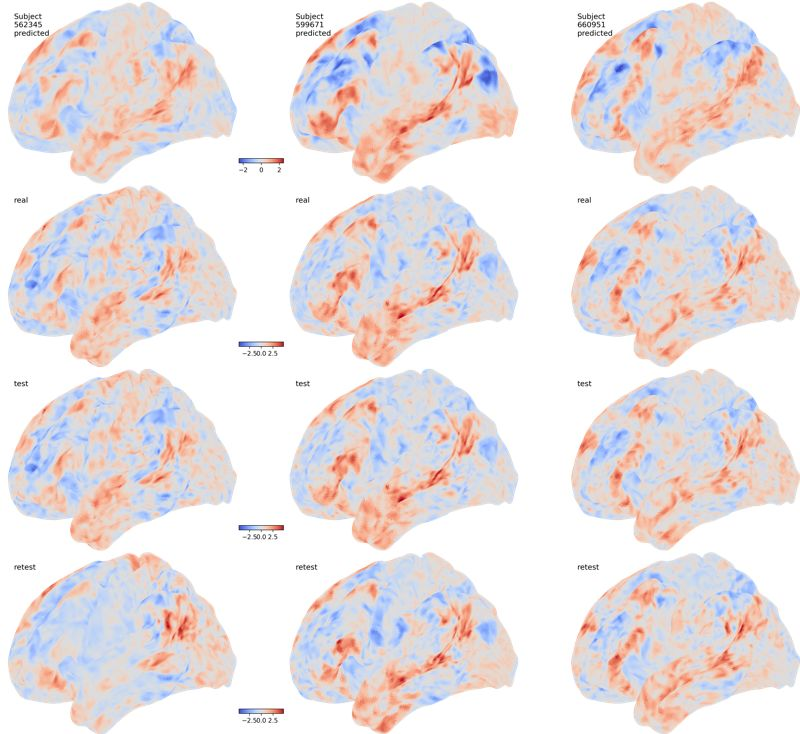

In [73]:
tn = list(unique_contrasts).index("LANGUAGE_STORY-MATH")
yd = (y_test_pred[index_in_big], y_test[index_in_big], payload["test_data"][index_in_rts], payload["retest_data"][index_in_rts])
img = plot_sample_predictions2(tn, test_subjs[index_in_big], yd, plot_subjs = [0,1,2], max_from="self", lc=-.36, row_labels=rl)
#img.save("results/plots/structural_maps-language.predictions+rt_bl.spatial_zscore.yfull.png")
img

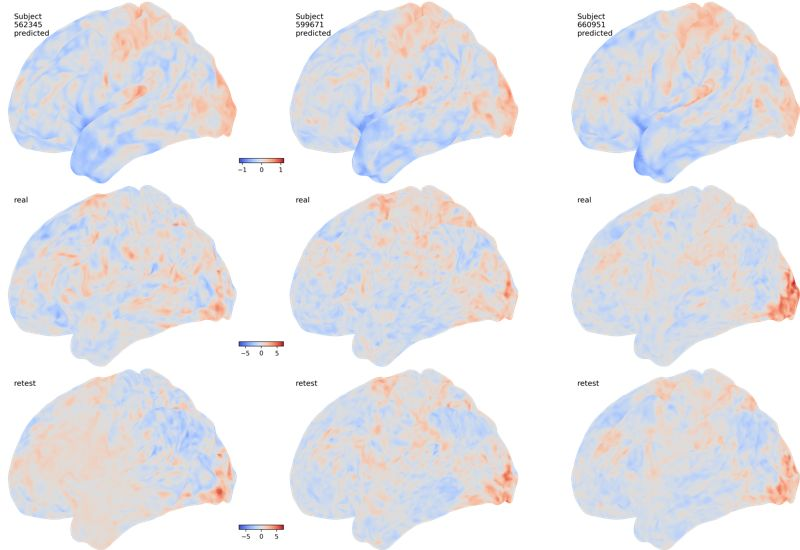

In [130]:
tn = list(unique_contrasts).index("MOTOR_CUE-AVG")
yd = (y_test_pred[index_in_big], y_test[index_in_big], payload["retest_data"][index_in_rts])
img = plot_sample_predictions2(tn, test_subjs[index_in_big], yd, plot_subjs = [0,1,2], max_from="self", lc=-.36)
img.save("results/plots/structural_maps-motor.predictions+rt_bl.spatial_zscore.yfull.png")
img

## Plot the prediction coefficients

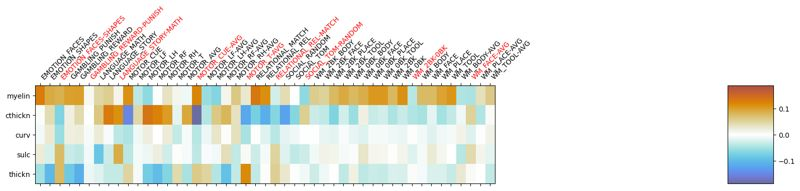

In [133]:
coeffs = regr_data[modality].skr.coef_ # shape (10, 224)
v = np.absolute(coeffs).max()
ax = plt.figure(figsize=(20,8)).gca()
im = ax.matshow(coeffs.T, cmap =cmap_coeffs , vmin=-v, vmax=v, aspect=2);  fxdcolorbar(im, ax = ax);
plt.xticks(np.arange(len(unique_contrasts)), unique_contrasts, rotation=45, ha="left")
for label in np.array(ax.get_xticklabels())[contrast_ids_to_show]: label.set_color("red")
ylabels = ["myelin", "cthickn", "curv", "sulc", "thickn"]
plt.yticks(np.arange(len(ylabels)), ylabels);
plt.tight_layout()
#plt.savefig("results/plots/structural_maps.lin_weights.spatial_zscore.yfull.svg")
plt.savefig("results/plots/structural_maps.lin_weights.all_tasks.spatial_zscore.yfull.png")

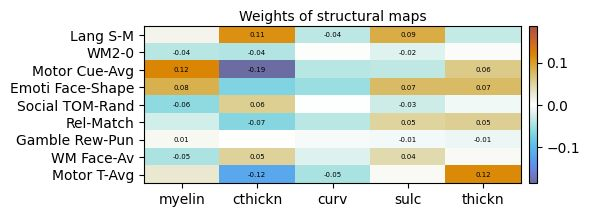

In [101]:
fig, axs = plt.subplots(1,1, figsize=(6,3)) # 4 plots in a row
axs=[axs];

coeffs2show = coeffs[contrast_ids_to_show,:]
best_coefficients = np.argsort(np.absolute(coeffs2show), axis=1)[:,::-1]

n_comps = 30;
data = coeffs2show[:,:n_comps]

aspr=(data.shape[1]/data.shape[0])/2.4
im = axs[0].matshow(data, cmap = cmap_coeffs, vmin=-v, vmax=v, aspect=aspr); 
for (i, j), z in np.ndenumerate(coeffs2show): 
  if j in best_coefficients[i,:3]: plt.text(j, i, '{:.2f}'.format(z), ha='center', va='center', size=5)

plt.colorbar(im,fraction=0.020, pad=0.02, ax=axs[0]);#fxdcolorbar(im, ax=axs[0]);#plt.colorbar(im, ax=axs[0]);
axs[0].set_yticks(np.arange(len(tnames_mid))); axs[0].set_yticklabels( tnames_mid);
axs[0].set_xlabel(f"Weights of structural maps"); axs[0].xaxis.set_label_position('top') 
axs[0].set_xticks(np.arange(len(xlabels))); axs[0].set_xticklabels(xlabels);
axs[0].xaxis.set_ticks_position("bottom")
plt.tight_layout()

plt.savefig("results/plots/structural_maps.lin_weights.spatial_zscore.full.png")

In [102]:
idxs = np.argsort(np.abs(coeffs), axis=1)
for n in range(len(tnames_mid)):
  txt = f"five biggest coeffs for {tnames_mid[n]} ";
  tn = contrast_ids_to_show[n]
  print(txt, (44-len(txt))*" ", "at components:\t", end="")
  for c in idxs[tn][::-1][:5]:
     print(f"c{c}", coeffs[tn, c], end=" | ")
  print("")

five biggest coeffs for Lang S-M              at components:	c1 0.111081086 | c3 0.08845957 | c2 -0.03780265 | c4 -0.03394075 | c0 0.011859675 | 
five biggest coeffs for WM2-0                 at components:	c1 -0.04273974 | c0 -0.039859094 | c3 -0.019906163 | c4 0.0039453697 | c2 0.0021413534 | 
five biggest coeffs for Motor Cue-Avg         at components:	c1 -0.1866203 | c0 0.11952184 | c4 0.05900668 | c2 -0.0404981 | c3 -0.0363399 | 
five biggest coeffs for Emoti Face-Shape      at components:	c0 0.08499888 | c4 0.07471115 | c3 0.07419424 | c1 -0.06999002 | c2 -0.0546111 | 
five biggest coeffs for Social TOM-Rand       at components:	c0 -0.060804214 | c1 0.0557972 | c3 -0.029438902 | c4 -0.008948292 | c2 -0.00080468773 | 
five biggest coeffs for Rel-Match             at components:	c1 -0.0657625 | c4 0.053730663 | c3 0.049646765 | c2 -0.038836855 | c0 -0.025933316 | 
five biggest coeffs for Gamble Rew-Pun        at components:	c4 -0.011717978 | c3 -0.008146268 | c0 0.0072093983 | c2 -

# ------

# Try training only on a few subjs

In [518]:
# check out a different split
x_train, x_test, y_train, y_test = train_test_split(xdata[::-1], ydata[::-1], test_size=0.2, shuffle=False)
x_train[10:15].shape, y_test[10:15].shape

((5, 29696, 400), (5, 29696, 10))

In [ ]:
print(lmodel)
y_train, y_train_pred, y_test, y_test_pred, skr = predict_y_from_x(x_train[10:15], ydata[10:15], lmodel=lmodel, verbose=1)
scoresd, diff_scores_test = score(y_test_pred, y_test);
print("Differentiation:", diff_scores_test.round(3))

# Within-parcel (voxel-wise) models

[especially for SC and dist; brainnettome! or desikan killiani ...]

[Consistency in predicting functions from anatomical and functional connectivity profiles across the cortical cortex](https://www.biorxiv.org/content/10.1101/247130v1)


* we performed a regression analysis on each of the 210 cortical regions using both connectivities.
* connectivities from brannettome (210 cortical regions/seeds x 210cortical + 30 subcortical targets)
* To train the regression model on the ith cortical region, we concatenated all the voxels of each training subject’s ith cortical region into a column.
* Yi = Xi * βi + E, where Y is the t-statistical value of the contrast maps; X represents either functional connectivity or anatomical connectivity;


**another one?!**
https://academic.oup.com/cercor/article/26/4/1668/2366564

In [15]:
cache = {}

tnames = ["Lang", "WM2", "Motor Cue", "Emoti", "SocTOM", "Rel", "GRew" ,"WMFace", "MotorT"]
cids = [8, 38, 16, 2, 27, 24, 5, 44, 21]
at = np.arange(len(tnames))

z_score_predictors_along_dim = 1# 1 ~ along spatial axis; 0~ across subjects


In [17]:
from lib.plotting import plot_29k
from brainspace.utils.parcellation import reduce_by_labels, map_to_labels

# Get atlases:
"""
## HCP MMP1

import hcp_utils as hcp
print("HCP MMP1:\t",hcp.mmp.map_all[:29696].shape)
parcellation29k = hcp.mmp.map_all[:29696];
parcel_id_to_label = hcp.mmp.labels;
excl = 0
"""

## lausanne
from lib.dist_tools import load_cifti_parcellation
cifti2 = "/home/users/robert.scholz2/res/atlases/lausanne18_cammoun12/fsLR32k/lausanne08.sc4.fslr32k.LR.dlabel.nii";
label_data, parcel_id_to_label = load_cifti_parcellation(cifti2, structure="left_cortex", verbose=1)
print(label_data.shape)
parcellation29k = label_data[hcp.vertex_info['grayl']]
excl = 1 

regions = np.unique(parcellation29k)
len(regions), len(parcellation29k), regions[:4], len(label_data)

cifti_shape: (1, 64984)
BMA: 1 <nibabel.cifti2.cifti2_axes.BrainModelAxis object at 0x2b73cf6c2e50>
slice for strcuture: left_cortex slice(0, 32492, None)
label dict info: 225 items contained, first 10: {0: '???', 1: 'unknown', 2: 'lateralorbitofrontal_1', 3: 'lateralorbitofrontal_2', 4: 'lateralorbitofrontal_3', 5: 'lateralorbitofrontal_4', 6: 'lateralorbitofrontal_5', 7: 'lateralorbitofrontal_6', 8: 'lateralorbitofrontal_7', 9: 'parsorbitalis_1'}
label_data info: shape of  (32492,) i.e. [ 91. 104.  67. ... 195. 196. 195.]
unqiue label_data: 224 labels contained, i.e.: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
(32492,)


(224, 29696, array([1., 2., 3., 4.]), 32492)

In [45]:
def run_parcel_wise_model2(xdata, ydata, parcellation, excl, v=0):
    if v: print(xdata.shape, ydata.shape)
    #parcellation = lausanne#brainnettome_left#dk#desikan killiani
    #parcellation = dk
    parcel_values = np.unique(parcellation[parcellation!=excl])
    n_parcels = len(parcel_values)
    if v: print(parcellation.shape, n_parcels, np.unique(parcellation)[:10])
    
    # DIM 2: 0 ~ corr, 1 ~ differentiability
    parcel_scores = np.zeros((n_parcels, 2, ydata.shape[-1])) # n_parcels, 2, n_tasks
    parcel_coeffs = np.zeros((n_parcels, ydata.shape[-1],  xdata.shape[-1])) # n_parcels, n_tasks, n_predictors/coeffs
    parcel_intercepts = np.zeros((n_parcels, ydata.shape[-1])) # n_parcels, n_predictors
    
    x_train, x_test, y_train, y_test = train_test_split(xdata, ydata, test_size=0.2, shuffle=False)
    y_test_pred = np.zeros_like(y_test)
    
    for i, parcel_value in tqdm(enumerate(parcel_values), total=n_parcels): 
      #print(i, end=" ");
      parcel_indices = np.where(parcellation  == parcel_value)[0]
      x_train_parcel, y_train_parcel = x_train[:, parcel_indices, :], y_train[:, parcel_indices, :]

      x = x_train_parcel.reshape((-1, x_train_parcel.shape[-1]))
      y = y_train_parcel.reshape((-1, y_train_parcel.shape[-1]))

      skr = sklearn.linear_model.LinearRegression()
      skr.fit(x, y)
      x_val_parcel, y_val_parcel = x_test[:, parcel_indices, :], y_test[:, parcel_indices, :]
      xv = x_val_parcel.reshape((-1, x_test.shape[-1]))
      y_val_parcel_pred =skr.predict(xv).reshape(y_val_parcel.shape)
      y_test_pred[:, parcel_indices, :] = y_val_parcel_pred

      scoresd, diff_scores_test = score(y_val_parcel_pred, y_val_parcel)

      parcel_scores[i, 0, :] = scoresd.corr.mean(axis=0) # (n_tasks)
      parcel_scores[i, 1, :] = diff_scores_test
      parcel_coeffs[i, :, :] = skr.coef_;
      parcel_intercepts[i, :] = skr.intercept_;
        
    return parcel_scores, parcel_coeffs, parcel_intercepts, y_test, y_test_pred;
    

In [46]:
modality= 'FS-StructuralMaps'
comb_predictors = gather_modalities(subjs, [modality], pred_files, data_dir = data_dir, zscore_predictors=False, modality_cache=cache);
isubjs, xdata, ydata = load_xy_data(subjs, data_dir, comb_predictors, yfull_task_data)
if not(z_score_predictors_along_dim is None):
  print("z-scoring predictors along d=", z_score_predictors_along_dim)
  xdata = scipy.stats.zscore(xdata, axis= z_score_predictors_along_dim)

res = run_parcel_wise_model2(xdata, ydata, parcellation29k, excl=excl, v=1);
parcel_scores, parcel_coeffs, parcel_intercepts, y_test, y_test_pred = res



Loading from memory: FS-StructuralMaps


Concatenating predictors: 100%|██████████| 254/254 [00:00<00:00, 2468.47it/s]

Gathered data from 254 subjects. Per subject data is of shape: (29696, 5)
0 missing subjects:  []
z-scoring task maps along the spatial dimension


All 254 have task data attached to them
z-scoring predictors along d= 1
(254, 29696, 5) (254, 29696, 47)
(29696,) 223 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


100%|██████████| 223/223 [02:29<00:00,  1.49it/s]


In [48]:
fn = f"results/scores/within_parcel_models.lausanne.51test_subjs.47tasks.pca_with_real_and_pred_maps.from_zscored.yfull.npy"
sub_train, sub_test = train_test_split(subjs, test_size=0.2, shuffle=False)
pdata = dict(parcel_scores=parcel_scores, parcel_coeffs=parcel_coeffs, parcel_intercepts=parcel_intercepts, y_test=y_test, y_test_pred=y_test_pred, \
             test_subjs = sub_test, parcellation29k=parcellation29k, parcel_id_to_label=parcel_id_to_label)
np.save(fn, pdata);
!ls -ash {fn}

606M results/scores/within_parcel_models.lausanne.51test_subjs.47tasks.pca_with_real_and_pred_maps.from_zscored.yfull.npy


## Precompute all modalities

In [20]:
within_parcel_scores_dict = {}

for modality in tqdm(unimodal_regressors):#tqdm(['RS-PCA200', 'FS-StructuralMaps']): #tqdm(regr_data.keys()):
    print("#################")
    comb_predictors = gather_modalities(subjs, [modality], pred_files, data_dir = data_dir, zscore_predictors=False, modality_cache=cache);
    isubjs, xdata, ydata = load_xy_data(subjs, data_dir, comb_predictors, yfull_task_data)
    if not(z_score_predictors_along_dim is None):
      print("z-scoring predictors along d=", z_score_predictors_along_dim)
      xdata = scipy.stats.zscore(xdata, axis= z_score_predictors_along_dim)

    res = run_parcel_wise_model(xdata, ydata, parcellation29k, excl=excl, v=1);
    parcel_scores, parcel_coeffs, parcel_intercepts = res[:3];
    print(parcel_scores.shape)
    within_parcel_scores_dict[modality] = dict(parcel_scores=parcel_scores, parcel_coeffs=parcel_coeffs, parcel_intercepts=parcel_intercepts)


  0%|          | 0/7 [00:00<?, ?it/s]

#################



Concatenating predictors: 100%|██████████| 254/254 [00:02<00:00, 114.98it/s]


Gathered data from 254 subjects. Per subject data is of shape: (29696, 200)
0 missing subjects:  []
z-scoring task maps along the spatial dimension
All 254 have task data attached to them
z-scoring predictors along d= 1
(254, 29696, 200) (254, 29696, 47)
(29696,) 223 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]



 14%|█▍        | 1/7 [03:55<23:32, 235.34s/it]

(223, 2, 47)
#################



Concatenating predictors: 100%|██████████| 254/254 [00:02<00:00, 114.25it/s]


Gathered data from 254 subjects. Per subject data is of shape: (29696, 200)
0 missing subjects:  []
z-scoring task maps along the spatial dimension
All 254 have task data attached to them
z-scoring predictors along d= 1
(254, 29696, 200) (254, 29696, 47)
(29696,) 223 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]



 29%|██▊       | 2/7 [07:43<19:15, 231.14s/it]

(223, 2, 47)
#################



Concatenating predictors: 100%|██████████| 254/254 [00:00<00:00, 454.08it/s]


Gathered data from 247 subjects. Per subject data is of shape: (29696, 41)
7 missing subjects:  ['110613', '140117', '181131', '195849', '201515', '433839', '656657']
z-scoring task maps along the spatial dimension
All 247 have task data attached to them
z-scoring predictors along d= 1
(247, 29696, 41) (247, 29696, 47)
(29696,) 223 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]



 43%|████▎     | 3/7 [10:36<13:38, 204.63s/it]

(223, 2, 47)
#################



Concatenating predictors: 100%|██████████| 254/254 [00:02<00:00, 105.48it/s]


Gathered data from 254 subjects. Per subject data is of shape: (29696, 224)
0 missing subjects:  []
z-scoring task maps along the spatial dimension
All 254 have task data attached to them
z-scoring predictors along d= 1
(254, 29696, 224) (254, 29696, 47)
(29696,) 223 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]



 57%|█████▋    | 4/7 [14:38<10:58, 219.39s/it]

(223, 2, 47)
#################



Concatenating predictors: 100%|██████████| 254/254 [00:02<00:00, 101.92it/s]


Gathered data from 254 subjects. Per subject data is of shape: (29696, 200)
0 missing subjects:  []
z-scoring task maps along the spatial dimension
All 254 have task data attached to them
z-scoring predictors along d= 1
(254, 29696, 200) (254, 29696, 47)
(29696,) 223 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]



 71%|███████▏  | 5/7 [18:36<07:32, 226.18s/it]

(223, 2, 47)
#################



Concatenating predictors: 100%|██████████| 254/254 [00:02<00:00, 107.39it/s]


Gathered data from 254 subjects. Per subject data is of shape: (29696, 200)
0 missing subjects:  []
z-scoring task maps along the spatial dimension
All 254 have task data attached to them
z-scoring predictors along d= 1
(254, 29696, 200) (254, 29696, 47)
(29696,) 223 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]



 86%|████████▌ | 6/7 [22:33<03:49, 229.83s/it]

(223, 2, 47)
#################



Concatenating predictors: 100%|██████████| 254/254 [00:00<00:00, 6221.19it/s]


Gathered data from 254 subjects. Per subject data is of shape: (29696, 5)
0 missing subjects:  []
z-scoring task maps along the spatial dimension
All 254 have task data attached to them
z-scoring predictors along d= 1
(254, 29696, 5) (254, 29696, 47)
(29696,) 223 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]



100%|██████████| 7/7 [25:10<00:00, 215.81s/it]

(223, 2, 47)


In [35]:
fn = f"results/scores/within_parcel_models.lausanne.51test_subjs.47tasks.all_modalities.from_zscored.yfull.npy"
sub_train, sub_test = train_test_split(subjs, test_size=0.2, shuffle=False)
pdata = dict(within_parcel_scores_dict=within_parcel_scores_dict, test_subjs = sub_test, parcellation29k=parcellation29k, parcel_id_to_label=parcel_id_to_label)
np.save(fn, pdata);
!ls -ash {fn}

99M results/scores/within_parcel_models.lausanne.51test_subjs.47tasks.all_modalities.from_zscored.yfull.npy


/local/robert.scholz2_600937/ipykernel_56403/723204716.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  im = axs[i].matshow(parcel_scores[:,1,cids].T, aspect=5, vmin=0); plt.colorbar(im, ax=axs[i]); axs[i].set_yticklabels([""]+ tnames);


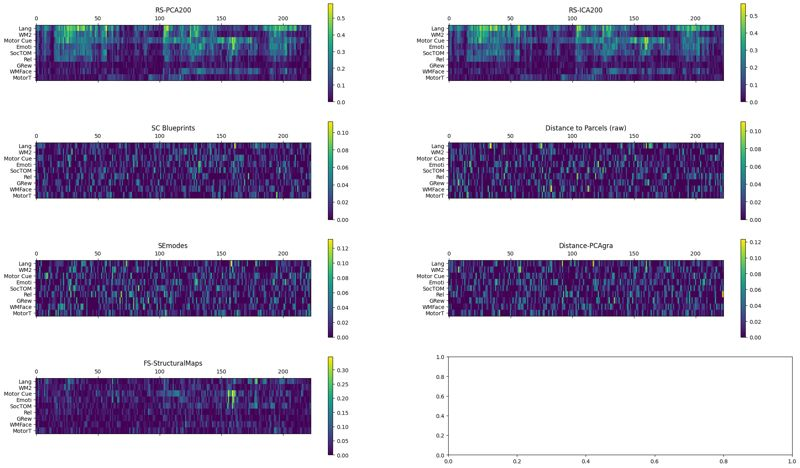

In [34]:
fig, axs = plt.subplots(4,2, figsize=(25,15)) # 4 plots in a row
axs=np.array(axs).flatten()
for i, modality in enumerate(unimodal_regressors):
    parcel_scores= within_parcel_scores_dict[modality]["parcel_scores"]
    im = axs[i].matshow(parcel_scores[:,1,cids].T, aspect=5, vmin=0); plt.colorbar(im, ax=axs[i]); axs[i].set_yticklabels([""]+ tnames);
    axs[i].set_title(modality)


## FCPCA

In [44]:
combination = ['RS-PCA200']; 
comb_predictors = gather_modalities(subjs, combination, pred_files, data_dir = data_dir, zscore_predictors=False, modality_cache=cache);
isubjs, xdata, ydata = load_xy_data(subjs, data_dir, comb_predictors, yfull_task_data)
if not(z_score_predictors_along_dim is None):
  print("z-scoring predictors along d=", z_score_predictors_along_dim)
  xdata = scipy.stats.zscore(xdata, axis= z_score_predictors_along_dim)
    
print(xdata.shape, ydata.shape)
res = run_parcel_wise_model(xdata, ydata, parcellation29k, excl=excl, v=1);
parcel_scores, parcel_coeffs, parcel_intercepts = res;
print(parcel_scores.shape)

Loading from memory: RS-PCA200


Concatenating predictors: 100%|██████████| 254/254 [00:03<00:00, 80.15it/s]


Gathered data from 254 subjects. Per subject data is of shape: (29696, 200)
0 missing subjects:  []
z-scoring task maps along the spatial dimension
All 254 have task data attached to them
z-scoring predictors along d= 1
(254, 29696, 200) (254, 29696, 47)
(254, 29696, 200) (254, 29696, 47)
(29696,) 223 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


100%|██████████| 223/223 [03:20<00:00,  1.11it/s]

(223, 2, 47)


In [48]:
fn = f"results/scores/within_parcel_models.lausanne.51test_subjs.47tasks.{combination[0]}.from_zscored.yfull.npy"
sub_train, sub_test = train_test_split(subjs, test_size=0.2, shuffle=False)
pdata = dict(parcel_scores=parcel_scores, test_subjs = sub_test, parcel_coeffs=parcel_coeffs, parcel_intercepts=parcel_intercepts, parcellation29k=parcellation29k)
np.save(fn, pdata);
!ls -ash {fn}

17M results/scores/within_parcel_models.lausanne.51test_subjs.47tasks.RS-PCA200.from_zscored.yfull.npy


/local/robert.scholz2_499227/ipykernel_543591/2147463856.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  im = axs[0].matshow(parcel_scores[:,0,cids].T, aspect=5, vmin=0); plt.colorbar(im, ax=axs[0]); axs[0].set_yticklabels([""]+ tnames);
/local/robert.scholz2_499227/ipykernel_543591/2147463856.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  im = axs[1].matshow(parcel_scores[:,1,cids].T, aspect=5, vmin=0); plt.colorbar(im, ax=axs[1]); axs[1].set_yticklabels([""]+ tnames);


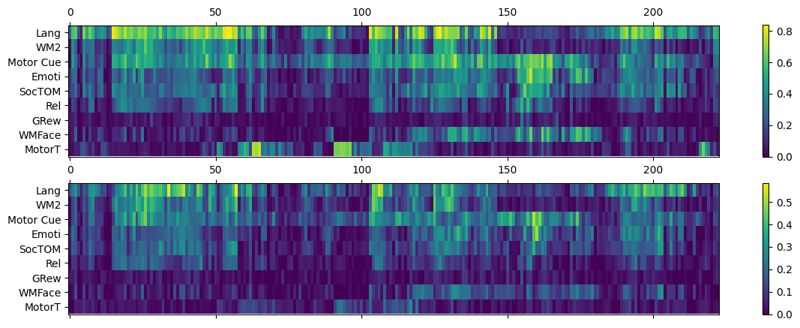

In [45]:
fig, axs = plt.subplots(2,1, figsize=(15,5)) # 4 plots in a row
im = axs[0].matshow(parcel_scores[:,0,cids].T, aspect=5, vmin=0); plt.colorbar(im, ax=axs[0]); axs[0].set_yticklabels([""]+ tnames);
im = axs[1].matshow(parcel_scores[:,1,cids].T, aspect=5, vmin=0); plt.colorbar(im, ax=axs[1]); axs[1].set_yticklabels([""]+ tnames);

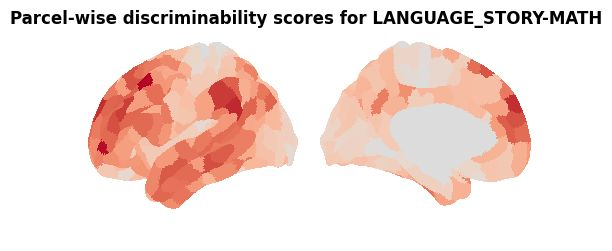

In [46]:
# show topography of how well each parcel is predicted
from lib.plotting import plot_29k
from brainspace.utils.parcellation import reduce_by_labels, map_to_labels
tn = list(unique_contrasts).index("LANGUAGE_STORY-MATH")
diff_per_area_lang = map_to_labels(parcel_scores[:,1,tn], parcellation29k, parcellation29k!=excl)
plot_29k(diff_per_area_lang, title= f"Parcel-wise discriminability scores for {unique_contrasts[tn]}", colorbar=None)

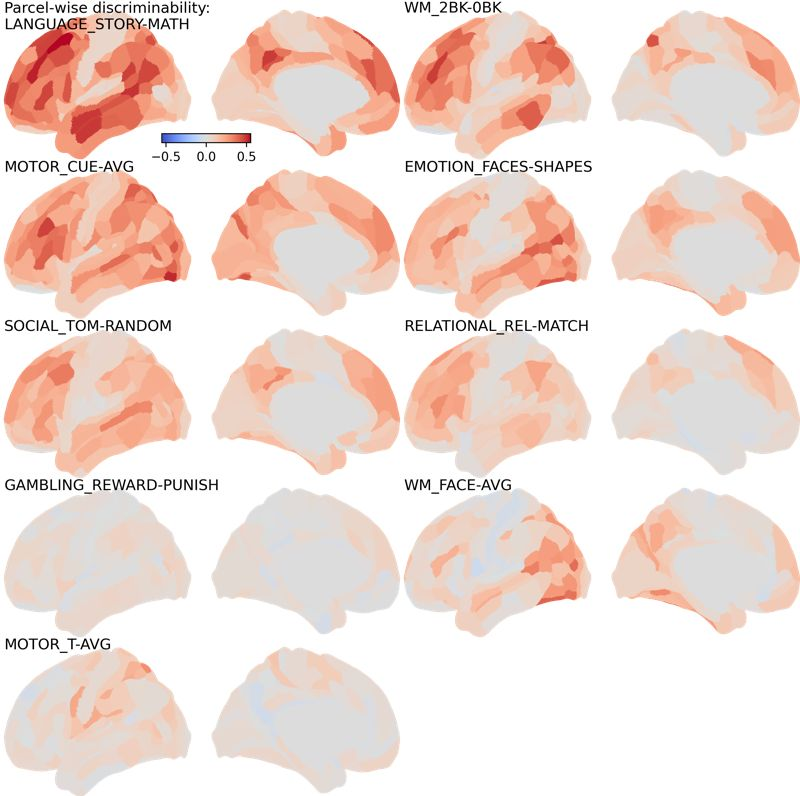

In [39]:
imgs = []

v = np.absolute(parcel_scores[:,1,cids].flatten()).max()

for tn in cids:
    diff_per_parcel = map_to_labels(parcel_scores[:,1,tn], parcellation29k, parcellation29k!=excl)
    #plot_29k(diff_per_area_lang)
    plot_29k(diff_per_parcel, title=None, cmap="coolwarm", colorbar=False, center_min_max=False, vmin=-v, vmax=v);
    name = ("Parcel-wise discriminability:\n" if tn==8 else "") + unique_contrasts[tn]
    plt.title(name,  y=1.0, x=-0.99, ha='left', va='top', pad=0) # weight='bold' if i==0 else -0.5
    imgs.append(fig2tightPIL(close_fig=1, dpi=300))
    
full_image = image_grid(imgs, 5,2)
cb = infer_colorbar(None, cminmax=0, vmin=-v,vmax=v, cmap="coolwarm", aspect=10, shrink=0.2);
cbimg = fig2tightPIL(cb.ax.get_figure(), dpi=300, format="png", close_fig=1)
#pwdiscrim_img = paste_centrally(full_image, cbimg, uc=0.78, lc=-0.49);
pwdiscrim_img = paste_centrally(full_image, cbimg, uc=-0.63, lc=-0.49);
pwdiscrim_img

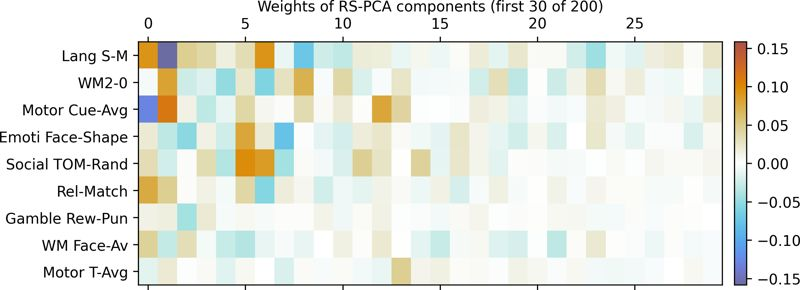

In [21]:
fig, axs = plt.subplots(1,1, figsize=(8,3.9)) # 4 plots in a row
axs=[axs];

coeffs2show = parcel_coeffs.mean(axis=0)[cids,:]
best_coefficients = np.argsort(np.absolute(coeffs2show), axis=1)[:,::-1]

n_comps = 30;
data = coeffs2show[:,:n_comps]

aspr=(data.shape[1]/data.shape[0])/2.4
im = axs[0].matshow(data, cmap = cmap_coeffs, vmin=-v, vmax=v, aspect=aspr); 
#for (i, j), z in np.ndenumerate(coeffs2show): 
#  if j in best_coefficients[i,:3]: plt.text(j, i, '{:.2f}'.format(z), ha='center', va='center', size=5)

plt.colorbar(im,fraction=0.020, pad=0.02, ax=axs[0]);#fxdcolorbar(im, ax=axs[0]);#plt.colorbar(im, ax=axs[0]);
axs[0].set_yticks(np.arange(len(tnames_mid))); axs[0].set_yticklabels( tnames_mid);
axs[0].set_xlabel(f"Weights of RS-PCA components (first {n_comps} of 200)"); axs[0].xaxis.set_label_position('top') 
plt.tight_layout()
#plt.savefig("results/plots/rs_pca.mean_parcelwise.lin_weights.30.spatial_zscore.yfull.png")
weights_img = fig2tightPIL(fig, dpi=300, format="png", close_fig=1)
weights_img.save("results/plots/rs_pca.mean_parcelwise.lin_weights.spatial_zscore.yfull.png")
weights_img

In [ ]:
from PIL import Image
#full_image = image_grid(imgs, 5,2)
wimgrs=weights_img.resize((np.array(weights_img.size) * 0.58).astype(int))
img = paste_centrally(pwdiscrim_img, wimgrs, uc=0.80, lc=0.51);
img.save("results/plots/rs_pca.parcelwise_diff+mean_lin_weights.spatial_zscore.yfull.png")

## Structural Maps

In [19]:
combination = ['FS-StructuralMaps']; 
comb_predictors = gather_modalities(subjs, combination, pred_files, data_dir = data_dir, zscore_predictors=False, modality_cache=cache);
isubjs, xdata, ydata = load_xy_data(subjs, data_dir, comb_predictors, yfull_task_data)
if not(z_score_predictors_along_dim is None):
  print("z-scoring predictors along d=", z_score_predictors_along_dim)
  xdata = scipy.stats.zscore(xdata, axis= z_score_predictors_along_dim)
    
print(xdata.shape, ydata.shape)
labels = ["myelin", "cthickn", "curv", "sulc", "thickn"]

res = run_parcel_wise_model(xdata, ydata, parcellation29k, excl=1, v=1);
parcel_scores, parcel_coeffs, parcel_intercepts = res;
print(parcel_scores.shape)

Loading from memory: FS-StructuralMaps


Concatenating predictors: 100%|██████████| 254/254 [00:00<00:00, 1761.36it/s]

Gathered data from 254 subjects. Per subject data is of shape: (29696, 5)


0 missing subjects:  []
z-scoring task maps along the spatial dimension
All 254 have task data attached to them
z-scoring predictors along d= 1
(254, 29696, 5) (254, 29696, 47)
(254, 29696, 5) (254, 29696, 47)
(29696,) 223 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


100%|██████████| 223/223 [02:28<00:00,  1.50it/s]

(223, 2, 47)


In [50]:
fn = f"results/scores/within_parcel_models.lausanne.51test_subjs.47tasks.{combination[0]}.from_zscored.yfull.npy"
sub_train, sub_test = train_test_split(subjs, test_size=0.2, shuffle=False)
pdata = dict(parcel_scores=parcel_scores, test_subjs = sub_test, parcel_coeffs=parcel_coeffs, parcel_intercepts=parcel_intercepts, parcellation29k=parcellation29k)
np.save(fn, pdata);
!ls -ash {fn}

892K results/scores/within_parcel_models.lausanne.51test_subjs.47tasks.FS-StructuralMaps.from_zscored.yfull.npy


/local/jobs/19613458/ipykernel_283355/2147463856.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  im = axs[0].matshow(parcel_scores[:,0,cids].T, aspect=5, vmin=0); plt.colorbar(im, ax=axs[0]); axs[0].set_yticklabels([""]+ tnames);
/local/jobs/19613458/ipykernel_283355/2147463856.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  im = axs[1].matshow(parcel_scores[:,1,cids].T, aspect=5, vmin=0); plt.colorbar(im, ax=axs[1]); axs[1].set_yticklabels([""]+ tnames);


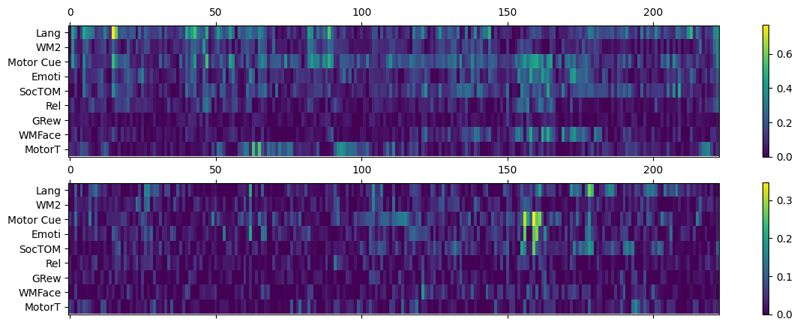

In [24]:
fig, axs = plt.subplots(2,1, figsize=(15,5)) # 4 plots in a row
im = axs[0].matshow(parcel_scores[:,0,cids].T, aspect=5, vmin=0); plt.colorbar(im, ax=axs[0]); axs[0].set_yticklabels([""]+ tnames);
im = axs[1].matshow(parcel_scores[:,1,cids].T, aspect=5, vmin=0); plt.colorbar(im, ax=axs[1]); axs[1].set_yticklabels([""]+ tnames);

In [27]:
pdata = dict(parcel_scores=parcel_scores, parcellation29k=parcellation29k, excl=excl, parcel_coeffs = parcel_coeffs)
fn = "results/scores/linear_regression_scores_and_info_v3.51test_subjs.47tasks.parcel-wise-model-scores.lausanne.from_zscored.yfull.npy"
np.save(fn, pdata)
!ls -ash {fn}

808K results/scores/linear_regression_scores_and_info_v3.51test_subjs.47tasks.parcel-wise-model-scores.lausanne.from_zscored.yfull.npy


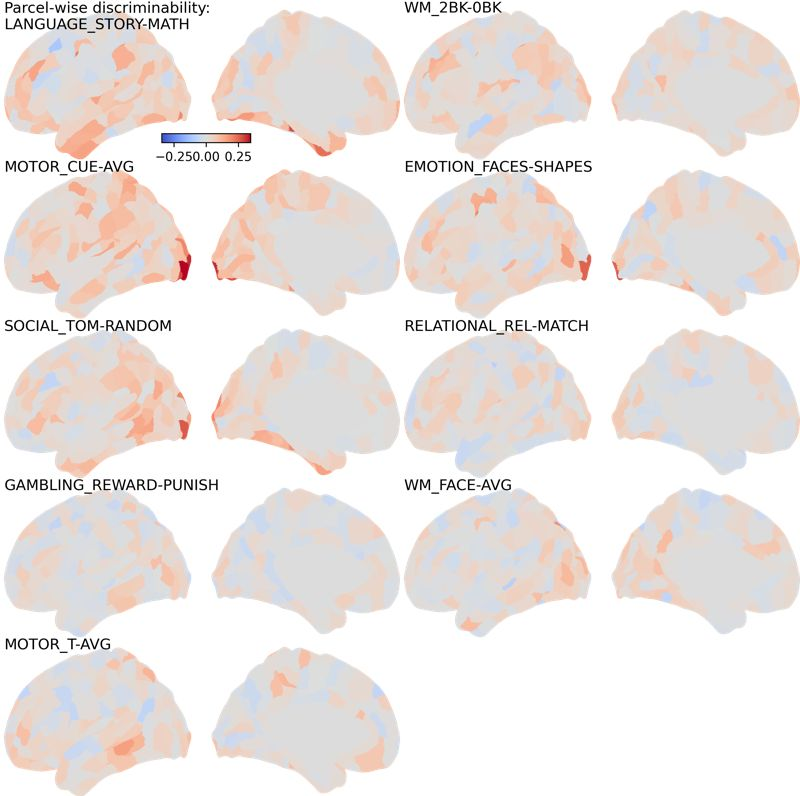

In [26]:
# show topography of how well each parcel is predicted

imgs = []
v = np.absolute(parcel_scores[:,1,cids].flatten()).max()

for tn in cids:
    diff_per_parcel = map_to_labels(parcel_scores[:,1,tn], parcellation29k, parcellation29k!=excl)
    #plot_29k(diff_per_area_lang)
    plot_29k(diff_per_parcel, title=None, cmap="coolwarm", colorbar=False, center_min_max=False, vmin=-v, vmax=v);
    name = ("Parcel-wise discriminability:\n" if tn==8 else "") + unique_contrasts[tn]
    plt.title(name,  y=1.0, x=-0.99, ha='left', va='top', pad=0) # weight='bold' if i==0 else -0.5
    imgs.append(fig2tightPIL(close_fig=1, dpi=300))
    
full_image = image_grid(imgs, 5,2)
cb = infer_colorbar(None, cminmax=0, vmin=-v,vmax=v, cmap="coolwarm", aspect=10, shrink=0.2);
cbimg = fig2tightPIL(cb.ax.get_figure(), dpi=300, format="png", close_fig=1)
#pwdiscrim_img = paste_centrally(full_image, cbimg, uc=0.78, lc=-0.49);
pwdiscrim_img = paste_centrally(full_image, cbimg, uc=-0.63, lc=-0.49);
pwdiscrim_img

/local/jobs/19613458/ipykernel_283355/1505035497.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels([""]+ labels);


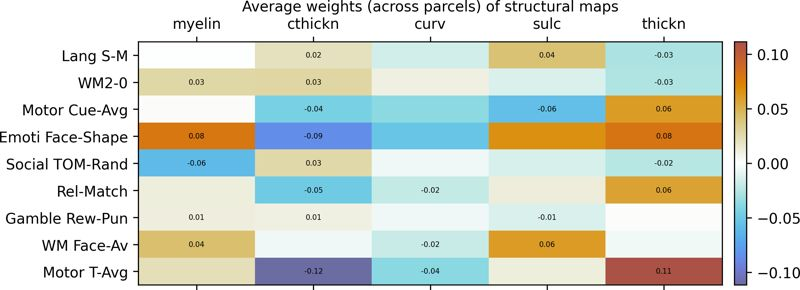

In [34]:
fig, axs = plt.subplots(1,1, figsize=(8,3.9)) # 4 plots in a row
axs=[axs];

v = parcel_coeffs.mean(axis=0).flatten().max()
coeffs2show = parcel_coeffs.mean(axis=0)[cids,:]
best_coefficients = np.argsort(np.absolute(coeffs2show), axis=1)[:,::-1]

n_comps = 30;
data = coeffs2show[:,:n_comps]

aspr=(data.shape[1]/data.shape[0])/2.4
im = axs[0].matshow(data, cmap = cmap_coeffs, vmin=-v, vmax=v, aspect=aspr); 
for (i, j), z in np.ndenumerate(coeffs2show): 
  if j in best_coefficients[i,:3]: plt.text(j, i, '{:.2f}'.format(z), ha='center', va='center', size=5)

plt.colorbar(im,fraction=0.020, pad=0.02, ax=axs[0]);#fxdcolorbar(im, ax=axs[0]);#plt.colorbar(im, ax=axs[0]);
axs[0].set_yticks(np.arange(len(tnames_mid))); axs[0].set_yticklabels( tnames_mid);
axs[0].set_xticklabels([""]+ labels);
axs[0].set_xlabel(f"Average weights (across parcels) of structural maps"); axs[0].xaxis.set_label_position('top') 
plt.tight_layout()

weights_img = fig2tightPIL(fig, dpi=300, format="png", close_fig=1)
weights_img.save("results/plots/structural_maps.mean_parcelwise.lin_weights.spatial_zscore.yfull.png")
weights_img

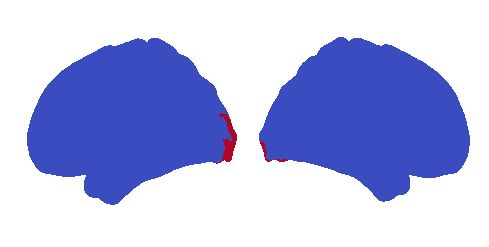

In [91]:
tn = list(unique_contrasts).index("MOTOR_CUE-AVG")
sorted_ids = np.argsort(parcel_scores[:,1,:], axis=0)[::-1,:]
x=np.zeros_like(sorted_ids[:,tn])
x[sorted_ids[:5,tn]]=2#*(np.arange(5)+1)
#diff_per_parcel = map_to_labels(parcel_scores[:,1,tn], parcellation29k, parcellation29k!=excl)
diff_per_parcel = map_to_labels(x, parcellation29k, parcellation29k!=excl)
plot_29k(diff_per_parcel, title=None, cmap="coolwarm", colorbar=False, center_min_max=False);

/local/robert.scholz2_582755/ipykernel_228048/3625696479.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels([""]+ labels);


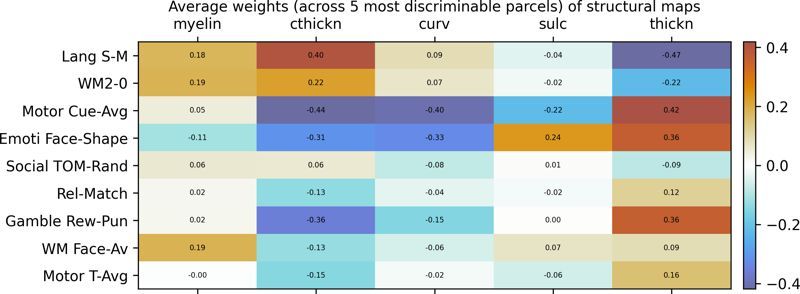

In [94]:
fig, axs = plt.subplots(1,1, figsize=(8,3.9)) # 4 plots in a row
axs=[axs];


coeffs2show = []
for tn in cids:
    coeffs2show.append(parcel_coeffs[sorted_ids[:5,tn],tn, :].mean(axis=0))

    
coeffs2show=np.array(coeffs2show)
best_coefficients = np.argsort(np.absolute(coeffs2show), axis=1)[:,::-1]

v = coeffs2show.flatten().max()

n_comps = 30;
data = coeffs2show[:,:n_comps]

aspr=(data.shape[1]/data.shape[0])/2.4
im = axs[0].matshow(data, cmap = cmap_coeffs, vmin=-v, vmax=v, aspect=aspr); 
for (i, j), z in np.ndenumerate(coeffs2show): 
  #if j in best_coefficients[i,:3]: plt.text(j, i, '{:.2f}'.format(z), ha='center', va='center', size=5)
  if j in best_coefficients[i,:5]: plt.text(j, i, '{:.2f}'.format(z), ha='center', va='center', size=5)

plt.colorbar(im,fraction=0.020, pad=0.02, ax=axs[0]);#fxdcolorbar(im, ax=axs[0]);#plt.colorbar(im, ax=axs[0]);
axs[0].set_yticks(np.arange(len(tnames_mid))); axs[0].set_yticklabels( tnames_mid);
axs[0].set_xticklabels([""]+ labels);
axs[0].set_xlabel(f"Average weights (across 5 most discriminable parcels) of structural maps"); axs[0].xaxis.set_label_position('top') 
plt.tight_layout()

weights_img = fig2tightPIL(fig, dpi=300, format="png", close_fig=1)
weights_img



In [ ]:
from PIL import Image
#full_image = image_grid(imgs, 5,2)
wimgrs=weights_img.resize((np.array(weights_img.size) * 0.58).astype(int))
img = paste_centrally(pwdiscrim_img, wimgrs, uc=0.80, lc=0.51);
img.save("results/plots/structural_maps.parcelwise_disc+mean_lin_weights.spatial_zscore.yfull.png")


**it seems like at least in specific subregions, cortical structure is predictive of function**

# Saving data for external plotting

In [25]:
## loading the full prediction results, and saving a subset of those into a smaller file
import numpy as np
from sklearn.model_selection import train_test_split

fn = "results/scores/linear_regression_scores_and_info_v3.yfull.aa.extended.npy"
regr_data = np.load(fn, allow_pickle=1).item();
print(regr_data.keys())

reg_data2 = {}
for modality in ['RS-PCA200', 'FS-StructuralMaps']: 
  reg_data2[modality] = {k:v for k,v in reg_data[modality].items() if not(k in ["y_train_pred", "y_train", "isubjs"])}
  sub_train, sub_test = train_test_split(reg_data[modality]["isubjs"], test_size=0.2, shuffle=False)
  reg_data2[modality]['sub_test'] = sub_test

#sizeof_fmt(deepsizeof(reg_data2))
fn = "results/scores/linear_regression_scores_and_info_v3.yfull.aa.extended.small.npy"
np.save(fn, reg_data2)
!ls -ash {fn}

1.1G results/scores/linear_regression_scores_and_info_v3.yfull.aa.extended.small.npy


In [47]:
# saving the predictors
## RS-PCA =
comb_predictors = gather_modalities(subjs, ["RS-PCA200"], pred_files, data_dir = data_dir, zscore_predictors=False, modality_cache={});
isubjs, xdata, ydata = load_xy_data(subjs, data_dir, comb_predictors, yfull_task_data)
print(xdata.shape)
xtrain, xtest = train_test_split(xdata, test_size=0.2, shuffle=False)
print(xtrain.shape, xtest.shape)
fn = "data/xdata_rspca.51subj.200comps.test.yfull.npy"
np.save(fn, xtest)
!ls -ash {fn}

## FS-StructuralMaps
combination =  ['FS-StructuralMaps']
comb_predictors = gather_modalities(subjs,combination, pred_files, data_dir = data_dir, zscore_predictors=False, modality_cache={});
isubjs, xdata, ydata = load_xy_data(subjs, data_dir, comb_predictors, yfull_task_data)
xtrain, xtest = train_test_split(xdata, test_size=0.2, shuffle=False)
fn = "data/xdata_microstruc.51subj.test.yfull.npy"
np.save(fn, xtest)
!ls -ash {fn}

(254, 29696, 200)
(203, 29696, 200) (51, 29696, 200)
1.4G data/xdata_rspca.51subj.200comps.test.npy
